<a href="https://colab.research.google.com/github/AlexandreBourrieau/ML/blob/main/Carnets%20Jupyter/S%C3%A9ries%20temporelles/PredictionSeries.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Chargement des données

In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import pandas as pd

In [2]:
!wget --no-check-certificate --content-disposition "https://raw.githubusercontent.com/AlexandreBourrieau/ML/main/Carnets%20Jupyter/S%C3%A9ries%20temporelles/data/table-indicateurs-open-data-dep-serie.csv"

--2021-04-23 15:52:58--  https://raw.githubusercontent.com/AlexandreBourrieau/ML/main/Carnets%20Jupyter/S%C3%A9ries%20temporelles/data/table-indicateurs-open-data-dep-serie.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4340764 (4.1M) [text/plain]
Saving to: ‘table-indicateurs-open-data-dep-serie.csv’

table-indicateurs-o 100%[===================>]   4.14M  23.5MB/s    in 0.2s    

2021-04-23 15:52:58 (23.5 MB/s) - ‘table-indicateurs-open-data-dep-serie.csv’ saved [4340764/4340764]



Charge la série sous Pandas et affiche les informations du fichier :

In [197]:
# Création de la série sous Pandas
serie = pd.read_csv("table-indicateurs-open-data-dep-serie.csv")
serie

,extract_date,departement,region,libelle_reg,libelle_dep,tx_incid,R,taux_occupation_sae,tx_pos,tx_incid_couleur,R_couleur,taux_occupation_sae_couleur,tx_pos_couleur,nb_orange,nb_rouge
0,2020-03-20,01,84,Auvergne Rhône Alpes,Ain,NaN,NaN,15.6,NaN,NaN,NaN,vert,NaN,0,0
1,2020-03-21,01,84,Auvergne Rhône Alpes,Ain,NaN,NaN,15.7,NaN,NaN,NaN,vert,NaN,0,0
2,2020-03-19,01,84,Auvergne Rhône Alpes,Ain,NaN,NaN,14.1,NaN,NaN,NaN,vert,NaN,0,0
3,2020-03-18,01,84,Auvergne Rhône Alpes,Ain,NaN,NaN,6.3,NaN,NaN,NaN,vert,NaN,0,0
4,2020-04-28,01,84,Auvergne Rhône Alpes,Ain,NaN,NaN,72.6,NaN,NaN,NaN,rouge,NaN,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40496,2021-04-15,84,93,Provence Alpes Côte d'Azur,Vaucluse,403.39,0.92,124.6,12.075129,rouge,vert,rouge,rouge,0,3
40497,2021-04-16,84,93,Provence Alpes Côte d'Azur,Vaucluse,408.38,NaN,127.4,12.472100,rouge,NaN,rouge,rouge,0,3
40498,2021-04-13,84,93,Provence Alpes Côte d'Azur,Vaucluse,434.58,NaN,124.3,12.066320,rouge,NaN,rouge,rouge,0,3
40499,2021-04-18,84,93,Provence Alpes Côte d'Azur,Vaucluse,396.26,NaN,124.3,12.487361,rouge,NaN,rouge,rouge,0,3


In [207]:
serie.groupby(by="region").agg(['count'])

,extract_date,departement,libelle_reg,libelle_dep,tx_incid,R,taux_occupation_sae,tx_pos,tx_incid_couleur,R_couleur,taux_occupation_sae_couleur,tx_pos_couleur,nb_orange,nb_rouge
,count,count,count,count,count,count,count,count,count,count,count,count,count,count
region,,,,,,,,,,,,,,
1,401,401,401,401,342,54,401,336,342,54,401,336,401,401
2,401,401,401,401,342,56,401,336,342,56,401,336,401,401
3,401,401,401,401,342,68,401,336,342,68,401,336,401,401
4,401,401,401,401,342,55,401,336,342,55,401,336,401,401
6,401,401,401,401,342,35,401,336,342,35,401,336,401,401
11,3208,3208,3208,3208,2736,544,3208,2688,2736,544,3208,2688,3208,3208
24,2406,2406,2406,2406,2052,408,2406,2016,2052,408,2406,2016,2406,2406
27,3208,3208,3208,3208,2736,544,3208,2688,2736,544,3208,2688,3208,3208


Regardons l'évolution du taux d'incidence sur paris :

In [208]:
serie_paris = serie.loc[serie['region']==84]
serie_paris = serie_paris[['extract_date','tx_incid']]

serie_paris

,extract_date,tx_incid
0,2020-03-20,NaN
1,2020-03-21,NaN
2,2020-03-19,NaN
3,2020-03-18,NaN
4,2020-04-28,NaN
...,...,...
4807,2021-04-16,291.40
4808,2021-04-13,330.15
4809,2021-04-18,281.02
4810,2021-04-19,264.48


In [209]:
df_paris = pd.DataFrame(data={'taux' : serie_paris['tx_incid'].values},index=serie_paris['extract_date'])
df_paris.index = pd.to_datetime(df_paris.index)
df_paris = df_paris[~df_paris.index.duplicated(keep='first')]
df_paris

,taux
extract_date,
2020-03-20,NaN
2020-03-21,NaN
2020-03-19,NaN
2020-03-18,NaN
2020-04-28,NaN
...,...
2020-09-27,80.22
2020-09-28,75.20
2020-09-29,75.50


In [210]:
df_paris.index = df_paris.index.sort_values()
df_paris

,taux
extract_date,
2020-03-18,NaN
2020-03-19,NaN
2020-03-20,NaN
2020-03-21,NaN
2020-03-22,NaN
...,...
2021-04-18,80.22
2021-04-19,75.20
2021-04-20,75.50


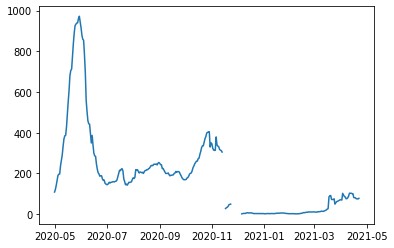

In [211]:
plt.plot(df_paris)

# Pré-traitement des données

In [212]:
# Affichage du nombre total de données manquantes

data_manquantes = sum(np.isnan(df_paris['taux']))
print ("Nombre de données manquantes : %s" %data_manquantes)

Nombre de données manquantes : 59


**3. Correction des données**

Pour corriger les données, on va tout simplement utiliser la fonction [fillna](https://pandas.pydata.org/docs/reference/api/pandas.Series.fillna.html) de Pandas avec la fonctionnalité de type `backfill` :

In [213]:
# Applique la fonction de remplissage automatique des données non numérique avec l'option backfill
df_paris = df_paris.interpolate(method="slinear")
data_manquantes = sum(np.isnan(df_paris['taux']))
print ("Nombre de données manquantes : %s" %data_manquantes)

Nombre de données manquantes : 44


In [214]:
df_paris = df_paris.fillna(method="backfill")
data_manquantes = sum(np.isnan(df_paris['taux']))
print ("Nombre de données manquantes : %s" %data_manquantes)

Nombre de données manquantes : 0


**4. Affichage des données**

Text(0.5, 1.0, 'Evolution du prix du BTC')

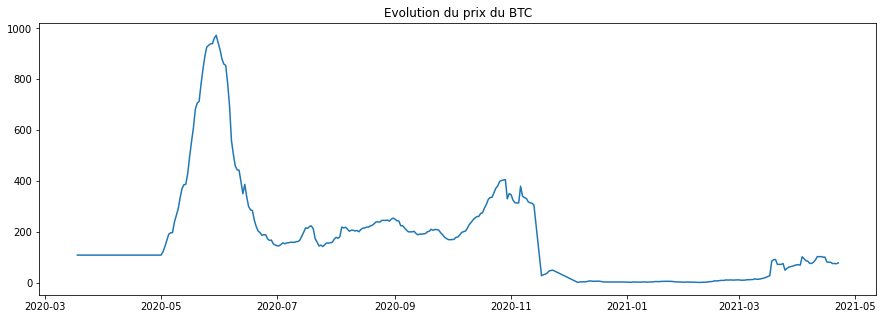

In [215]:
# Affiche la série
plt.figure(figsize=(15,5))
plt.plot(df_paris)
plt.title("Evolution du prix du BTC")

# Préparation des données

**2. Détection des anomalies dans la série "horaire"**

Les anomalies sont fréquentes dans les séries temporelles, et la performance des prédictions est souvent améliorée lorsque ces anomalies sont traitées.  
Pour avoir un apperçu de ces éventuelles anomalies, nous allons utiliser la méthode ["Isolation Forest"](https://scikit-learn.org/stable/modules/outlier_detection.html#isolation-forest) disponnible dans Scikit-learn.  

Les paramètres utilisés sont les suivants :
 - **n_estimators** : C'est le nombre de sous-groupes d'échantillons à utiliser. Une valeur de 128 ou 256 est préconnisée dans le document de recherche.
 - **max_samples** : C'est le nombre d'échantillons maximum à utiliser. Nous utiliserons l'ensemble des échantillons.
 - **max_features** :  C'est le nombre de motifs aléatoirement choisis sur chaque noeud de l'arbre. Nous choisirons un seul motif.
 - **contamination** : C'est le pourcentage estimé d'anomalies dans les données. Ce paramètre permet de régler la sensibilité de l'algorithme. On va commencer avec 5% et affiner si nécessaire par la suite.

In [221]:
# Initialise le modèle
from sklearn.ensemble import IsolationForest

clf = IsolationForest(n_estimators=256,max_samples=df_paris['taux'].size, contamination=0.01,max_features=1, verbose=1)
clf.fit(df_paris['taux'].values.reshape(-1,1))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s finished


IsolationForest(behaviour='deprecated', bootstrap=False, contamination=0.01,
                max_features=1, max_samples=401, n_estimators=256, n_jobs=None,
                random_state=None, verbose=1, warm_start=False)

In [222]:
# Réalise les prédictions
pred = clf.predict(df_paris['taux'].values.reshape(-1,1))
pred

array([ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1,  1,  1,  1,  1, -1,  1,
        1,  1,  1,  1, -1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1

On ajoute maintenant ces informations dans la série journalière et on affiche les informations :

In [223]:
# Ajoute une colonne "Anomalie" dans la série
df_paris['Anomalies']=pred
df_paris['Anomalies'] = df_paris['Anomalies'].apply(lambda x: 1 if (x==-1) else 0)
df_paris

,taux,Anomalies
extract_date,,
2020-03-18,108.53,0
2020-03-19,108.53,0
2020-03-20,108.53,0
2020-03-21,108.53,0
2020-03-22,108.53,0
...,...,...
2021-04-18,80.22,0
2021-04-19,75.20,0
2021-04-20,75.50,0


In [224]:
# Affiche les informations sur les anomalies
print(df_paris['Anomalies'].value_counts())

0    397
1      4
Name: Anomalies, dtype: int64


**3. Affichage des anomalies sur le graphique**

In [225]:
# Affiche la série

fig = px.line(x=df_paris.index,y=df_paris['taux'],title="Evolution du prix du BTC")
fig.add_trace(px.scatter(x=df_paris.index,y=df_paris['Anomalies']*df_paris['taux'],color=df_paris['Anomalies'].astype(np.bool)).data[0])

fig.update_xaxes(rangeslider_visible=True)
yaxis=dict(autorange = True,fixedrange= False)
fig.update_yaxes(yaxis)
fig.show()

Comme les anomalies détectées ne sembles pas cohérentes, nous n'allons pas les traiter...

# Analyse de la série

In [226]:
df_paris

,taux,Anomalies
extract_date,,
2020-03-18,108.53,0
2020-03-19,108.53,0
2020-03-20,108.53,0
2020-03-21,108.53,0
2020-03-22,108.53,0
...,...,...
2021-04-18,80.22,0
2021-04-19,75.20,0
2021-04-20,75.50,0


**1. ACF & PACF**

/usr/local/lib/python3.7/dist-packages/statsmodels/regression/linear_model.py:1358: RuntimeWarning:

invalid value encountered in sqrt



Text(0.5, 1.0, 'Autocorrélation partielle du bruit blanc')

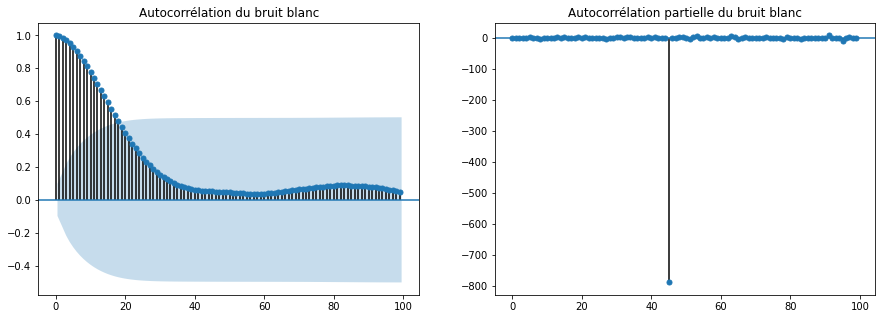

In [235]:
# ACF & PACF du bruit blanc

serie = df_paris['taux']

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

f1, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
f1.subplots_adjust(hspace=0.3,wspace=0.2)

plot_acf(serie, ax=ax1, lags = range(0,100))
ax1.set_title("Autocorrélation du bruit blanc")

plot_pacf(serie, ax=ax2, lags = range(0, 100))
ax2.set_title("Autocorrélation partielle du bruit blanc")

**2. Test de Dickey-Fuller**

In [228]:
import statsmodels.api as sm

serie_test = serie

adf, p, usedlag, nobs, cvs, aic = sm.tsa.stattools.adfuller(serie_test)

adf_results_string = 'ADF: {}\np-value: {},\nN: {}, \ncritical values: {}'
print(adf_results_string.format(adf, p, nobs, cvs))

ADF: -3.2152287548025362
p-value: 0.019119929430470778,
N: 390, 
critical values: {'1%': -3.4472291365835566, '5%': -2.8689795375849223, '10%': -2.5707330834976987}


**3. Suppression de la tendance non linéaire et test de sationnarité**

In [ ]:
from scipy.stats import boxcox

serie_log, lam = boxcox(serie)

f1, (ax1,ax2) = plt.subplots(2, 1, figsize=(15, 5))
ax1.plot(serie_etude.index,serie_log)
ax2.plot(serie_etude.index,serie)

In [ ]:
import statsmodels.api as sm

serie_test = serie_log

adf, p, usedlag, nobs, cvs, aic = sm.tsa.stattools.adfuller(serie_test)

adf_results_string = 'ADF: {}\np-value: {},\nN: {}, \ncritical values: {}'
print(adf_results_string.format(adf, p, nobs, cvs))

***4. Suppression de la tendance linéaire et test de stationnarité***

In [ ]:
f1, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 5))

# Calcul des coefficients
x = np.linspace(0,len(serie_log),len(serie_log))
coefs = np.polyfit(x,serie_log,1)

# Calcul de la tendance non linéaire
trend = coefs[0]*np.power(x,1) + coefs[1]

# Calcul de la série sans tendance
serie_log_detrend = serie_log - trend

# Affiche les résultats
ax1.plot(trend)
ax1.plot(serie_log)
ax1.set_title("Série originale et tendance non linéaire")

ax2.plot(serie_log_detrend)
ax2.set_title("Série avec tendance non linéaire supprimée")

In [ ]:
# ACF & PACF du bruit blanc

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

f1, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
f1.subplots_adjust(hspace=0.3,wspace=0.2)

plot_acf(serie_log_detrend, ax=ax1, lags = range(0,50))
ax1.set_title("Autocorrélation du bruit blanc")

plot_pacf(serie_log_detrend, ax=ax2, lags = range(0, 50))
ax2.set_title("Autocorrélation partielle du bruit blanc")

In [ ]:
import statsmodels.api as sm

serie_test = serie_log_detrend

adf, p, usedlag, nobs, cvs, aic = sm.tsa.stattools.adfuller(serie_test)

adf_results_string = 'ADF: {}\np-value: {},\nN: {}, \ncritical values: {}'
print(adf_results_string.format(adf, p, nobs, cvs))

**5. Différentiation**

In [ ]:
# Différenciation d'odre 1 et saisonnale à l'odre 1 et de période 12

from statsmodels.tsa.statespace.tools import diff

serie_log_detrend_diff1 = diff(serie_log_detrend,1)       # diff=1 ; diff_saison=1 ; periode = 12

plt.figure(figsize=(10, 6))
plt.plot(serie_log_detrend_diff1)
plt.title("Signal différencié d'ordre 1 + saisonalité")
plt.show()

In [ ]:
import statsmodels.api as sm

serie_test = serie_log_detrend_diff1

adf, p, usedlag, nobs, cvs, aic = sm.tsa.stattools.adfuller(serie_test)

adf_results_string = 'ADF: {}\np-value: {},\nN: {}, \ncritical values: {}'
print(adf_results_string.format(adf, p, nobs, cvs))

In [ ]:
# ACF & PACF du bruit blanc

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

f1, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
f1.subplots_adjust(hspace=0.3,wspace=0.2)

plot_acf(serie_log_detrend_diff1, ax=ax1, lags = range(0,50))
ax1.set_title("Autocorrélation du bruit blanc")

plot_pacf(serie_log_detrend_diff1, ax=ax2, lags = range(0, 50))
ax2.set_title("Autocorrélation partielle du bruit blanc")

**5. Enregistrement des données dans le dataframe**

In [ ]:
serie_log_detrend_diff1 = np.insert(serie_log_detrend_diff1,0,0)

In [ ]:
serie_etude['diff'] = serie_log_detrend_diff1
serie_etude['diff'][0] = "Nan"
serie_etude

# Prépartion des datasets

**1. Séparation des données en données pour l'entrainement et la validation**

On réserve 20% des données pour l'entrainement et le reste pour la validation :

In [381]:
# Sépare les données en entrainement et tests
pourcentage = 0.9
temps_separation = int(len(df_paris['taux']) * pourcentage)
date_separation = df_paris.index[temps_separation]

serie_entrainement = df_paris['taux'].iloc[:temps_separation]
serie_test = df_paris['taux'].iloc[temps_separation:]

print("Taille de l'entrainement : %d" %len(serie_entrainement))
print("Taille de la validation : %d" %len(serie_test))

Taille de l'entrainement : 360
Taille de la validation : 41


On normalise les données :

In [382]:
# Calcul de la moyenne et de l'écart type de la série
mean = tf.math.reduce_mean(np.asarray(serie_entrainement))
std = tf.math.reduce_std(np.asarray((serie_entrainement)))

# Normalisation des données
serie_entrainement = (serie_entrainement-mean)/std
serie_test = (serie_test-mean)/std

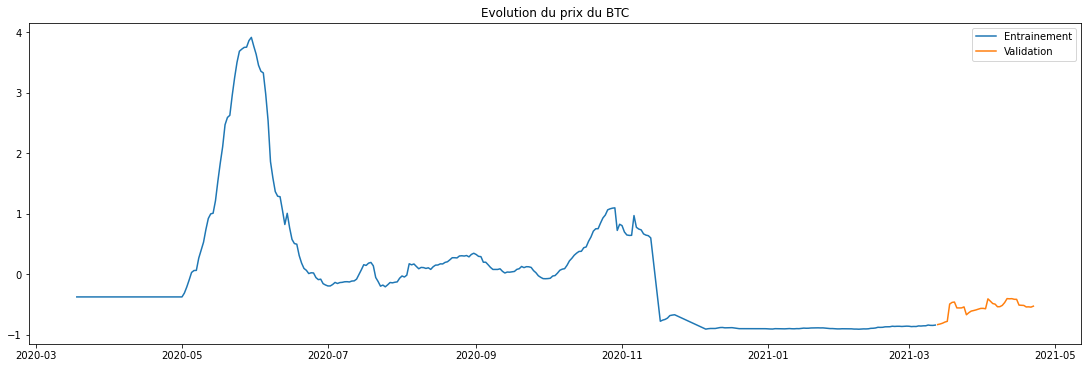

In [383]:
# Affiche la série
fig, ax = plt.subplots(constrained_layout=True, figsize=(15,5))
ax.plot(serie_entrainement, label="Entrainement")
ax.plot(serie_test,label="Validation")

ax.set_title("Evolution du prix du BTC")

ax.legend()
plt.show()

**2. Création des datasets**

In [369]:
# Fonction permettant de créer un dataset à partir des données de la série temporelle

def prepare_dataset_XY(serie, taille_fenetre, horizon, batch_size):
  dataset = tf.data.Dataset.from_tensor_slices(serie)
  dataset = dataset.window(taille_fenetre+horizon, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda x: x.batch(taille_fenetre + horizon))
  dataset = dataset.map(lambda x: (tf.expand_dims(x[0:taille_fenetre],axis=1),x[-1:]))
  dataset = dataset.batch(batch_size,drop_remainder=True).prefetch(1)
  return dataset

In [370]:
# Définition des caractéristiques du dataset que l'on souhaite créer
taille_fenetre = 200
horizon = 1
batch_size = 1

# Création du dataset
dataset = prepare_dataset_XY(serie_entrainement,taille_fenetre,horizon,batch_size)
dataset_val = prepare_dataset_XY(serie_test,taille_fenetre,horizon,batch_size)

In [371]:
print(len(list(dataset.as_numpy_iterator())))
for element in dataset.take(1):
  print(element[0].shape)
  print(element[1].shape)

160
(1, 200, 1)
(1, 1)


In [372]:
print(len(list(dataset_val.as_numpy_iterator())))
for element in dataset_val.take(1):
  print(element[0].shape)
  print(element[1].shape)

0


On extrait maintenant les deux tenseurs (X,Y) pour l'entrainement :

In [373]:
# Extrait les X,Y du dataset
#56x((1000,4,1),(1000,1)) => (56*1000,4,1) ; (56*1000,1)

x,y = tuple(zip(*dataset))

# Recombine les données
# (56,1000,4,1) => (56*128,4,1)
# (56,1000,1) => (56*128,1)
x_train = np.asarray(tf.reshape(np.asarray(x,dtype=np.float32),shape=(np.asarray(x).shape[0]*np.asarray(x).shape[1],taille_fenetre,1)))
y_train = np.asarray(tf.reshape(np.asarray(y,dtype=np.float32),shape=(np.asarray(y).shape[0]*np.asarray(y).shape[1])))

# Affiche les formats
print(x_train.shape)
print(y_train.shape)

(160, 200, 1)
(160,)


Puis la même chose pour les données de validation :

In [271]:
# Extrait les X,Y du dataset_val

x,y = tuple(zip(*dataset_val))

# Recombine les données

x_val = np.asarray(tf.reshape(np.asarray(x,dtype=np.float32),shape=(np.asarray(x).shape[0]*np.asarray(x).shape[1],taille_fenetre,1)))
y_val = np.asarray(tf.reshape(np.asarray(y,dtype=np.float32),shape=(np.asarray(y).shape[0]*np.asarray(y).shape[1])))

# Affiche les formats
print(x_val.shape)
print(y_val.shape)

(71, 10, 1)
(71,)


# Optimisation des hyperparamètres

**1. Création de la série horaire pour l'optimisation des hyperparamètres**

**3. Définition du modèle**

Dans le modèle, les paramètres dim_LSTM, l1_reg, l2_reg seront optimisés :

In [319]:
def ModelLSTM(dim_LSTM = 10, l1_reg=0, l2_reg=0):
  # Définition de l'entrée du modèle
  entrees = tf.keras.layers.Input(shape=(taille_fenetre,1),batch_size=batch_size)

  # Encodeur
  s_encodeur = tf.keras.layers.LSTM(dim_LSTM, kernel_regularizer=tf.keras.regularizers.l1_l2(l1=l1_reg,l2=l2_reg),stateful=True)(entrees)

  # Décodeur
  s_decodeur = tf.keras.layers.Dense(dim_LSTM,activation="tanh",kernel_regularizer=tf.keras.regularizers.l1_l2(l1=l1_reg,l2=l2_reg))(s_encodeur)
  s_decodeur = tf.keras.layers.Concatenate()([s_decodeur,s_encodeur])

  # Générateur
  sortie = tf.keras.layers.Dense(1,kernel_regularizer=tf.keras.regularizers.l1_l2(l1=l1_reg,l2=l2_reg))(s_decodeur)

  # Construction du modèle
  model = tf.keras.Model(entrees,sortie)
  model.comile(loss="mse", optimiser="adam")
  return(model)

**4. Cross-validation**

In [274]:
batch_size

1

In [374]:
from keras.callbacks import EarlyStopping
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import KFold, TimeSeriesSplit, GridSearchCV

# Définitions des paramètres
dim_LSTM = [5,10,15,20,30,40]
l1_reg = [0,0.001,0.01,0.1]
l2_reg = [0,0.001,0.01,0.1]

param_grid = {'dim_LSTM': dim_LSTM, 'l1_reg': l1_reg, 'l2_reg': l2_reg}

max_periodes = 5

# Surveillance de l'entrainement
es = EarlyStopping(monitor='loss', mode='min', verbose=1, patience=50, min_delta=1e-7, restore_best_weights=True)


tscv = TimeSeriesSplit(n_splits = 5)
model = KerasRegressor(build_fn=ModelLSTM, epochs=max_periodes, verbose=2)
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=tscv, n_jobs=1, verbose=3)

grid_result = grid.fit(x_train, y_train,callbacks=[es])

Fitting 5 folds for each of 96 candidates, totalling 480 fits
[CV] dim_LSTM=5, l1_reg=0, l2_reg=0 ..................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning:

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
AttributeError: 'Functional' object has no attribute 'comile'


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s


[CV] ........ dim_LSTM=5, l1_reg=0, l2_reg=0, score=nan, total=   0.2s
[CV] dim_LSTM=5, l1_reg=0, l2_reg=0 ..................................
[CV] ........ dim_LSTM=5, l1_reg=0, l2_reg=0, score=nan, total=   0.2s
[CV] dim_LSTM=5, l1_reg=0, l2_reg=0 ..................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.5s remaining:    0.0s


[CV] ........ dim_LSTM=5, l1_reg=0, l2_reg=0, score=nan, total=   0.2s
[CV] dim_LSTM=5, l1_reg=0, l2_reg=0 ..................................
[CV] ........ dim_LSTM=5, l1_reg=0, l2_reg=0, score=nan, total=   0.2s
[CV] dim_LSTM=5, l1_reg=0, l2_reg=0 ..................................
[CV] ........ dim_LSTM=5, l1_reg=0, l2_reg=0, score=nan, total=   0.2s
[CV] dim_LSTM=5, l1_reg=0, l2_reg=0.001 ..............................
[CV] .... dim_LSTM=5, l1_reg=0, l2_reg=0.001, score=nan, total=   0.2s
[CV] dim_LSTM=5, l1_reg=0, l2_reg=0.001 ..............................
[CV] .... dim_LSTM=5, l1_reg=0, l2_reg=0.001, score=nan, total=   0.2s
[CV] dim_LSTM=5, l1_reg=0, l2_reg=0.001 ..............................
[CV] .... dim_LSTM=5, l1_reg=0, l2_reg=0.001, score=nan, total=   0.2s
[CV] dim_LSTM=5, l1_reg=0, l2_reg=0.001 ..............................
[CV] .... dim_LSTM=5, l1_reg=0, l2_reg=0.001, score=nan, total=   0.2s
[CV] dim_LSTM=5, l1_reg=0, l2_reg=0.001 ..............................
[CV] .

KeyboardInterrupt: ignored

In [ ]:
# Affiche les résultats
print("Meilleur résultat : %f avec %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params_ = grid_result.cv_results_['params']
for mean, stdev, param_ in zip(means, stds, params_):
  print("%f (%f) with %r" % (mean, stdev, param_))

# Création du modèle LSTM de type encodeur-décodeur

**1. Création du réseau**

Par défaut, la dimension des vecteurs cachés est de 10 et aucune régularisation n'est utilisée.

In [375]:
dim_LSTM = 100
l1_reg = 0.0
l2_reg = 0.0

# Définition de l'entrée du modèle
entrees = tf.keras.layers.Input(shape=(taille_fenetre,1))

# Encodeur
s_encodeur = tf.keras.layers.LSTM(dim_LSTM, kernel_regularizer=tf.keras.regularizers.l1_l2(l1=l1_reg,l2=l2_reg),)(entrees)

# Décodeur
s_decodeur = tf.keras.layers.Dense(dim_LSTM,activation="tanh",kernel_regularizer=tf.keras.regularizers.l1_l2(l1=l1_reg,l2=l2_reg))(s_encodeur)
s_decodeur = tf.keras.layers.Concatenate()([s_decodeur,s_encodeur])

# Générateur
sortie = tf.keras.layers.Dense(1,kernel_regularizer=tf.keras.regularizers.l1_l2(l1=l1_reg,l2=l2_reg))(s_decodeur)

# Construction du modèle
model = tf.keras.Model(entrees,sortie)
model.summary()

Model: "model_77"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_81 (InputLayer)           [(None, 200, 1)]     0                                            
__________________________________________________________________________________________________
lstm_80 (LSTM)                  (None, 100)          40800       input_81[0][0]                   
__________________________________________________________________________________________________
dense_156 (Dense)               (None, 100)          10100       lstm_80[0][0]                    
__________________________________________________________________________________________________
concatenate_78 (Concatenate)    (None, 200)          0           dense_156[0][0]                  
                                                                 lstm_80[0][0]             

**2. Optimisation de l'apprentissage**

Pour accélérer le traitement des données, nous n'allons pas utiliser l'intégralité des données pendant la mise à jour du gradient, comme cela a été fait jusqu'à présent (en utilisant le dataset).  
Cette fois-ci, nous allons forcer les mises à jour du gradient à se produire de manière moins fréquente en attribuant la valeur du batch_size à prendre en compte lors de la regression du modèle.  
Pour cela, on utilise l'argument "batch_size" dans la méthode fit. En précisant un batch_size=1000, cela signifie que :
 - Sur notre total de 56000 échantillons, 56 seront utilisés pour les calculs du gradient
 - Il y aura également 56 itérations à chaque période.
  
    
    
Si nous avions pris le dataset comme entrée, nous aurions eu :
- Un total de 56000 échantillons également
- Chaque période aurait également pris 56 itérations pour se compléter
- Mais 1000 échantillons auraient été utilisés pour le calcul du gradient, au lieu de 56 avec la méthode utilisée.

In [347]:
# Définition de la fonction de régulation du taux d'apprentissage
def RegulationTauxApprentissage(periode, taux):
  return 1e-8*10**(periode/10)

# Définition de l'optimiseur à utiliser
optimiseur=tf.keras.optimizers.SGD()

# Compile le modèle
model.compile(loss="mse", optimizer=optimiseur, metrics="mse")

# Utilisation de la méthode ModelCheckPoint
CheckPoint = tf.keras.callbacks.ModelCheckpoint("poids.hdf5", monitor='loss', verbose=1, save_best_only=True, save_weights_only = True, mode='auto', save_freq='epoch')

# Entraine le modèle en utilisant notre fonction personnelle de régulation du taux d'apprentissage
historique = model.fit(dataset,epochs=100,verbose=1, callbacks=[tf.keras.callbacks.LearningRateScheduler(RegulationTauxApprentissage), CheckPoint],batch_size=batch_size)

Epoch 1/100
4/4 [==============================] - 1s 9ms/step - loss: 0.2976 - mse: 0.2976

Epoch 00001: loss improved from inf to 0.49595, saving model to poids.hdf5
Epoch 2/100
4/4 [==============================] - 0s 14ms/step - loss: 0.2976 - mse: 0.2976

Epoch 00002: loss improved from 0.49595 to 0.49595, saving model to poids.hdf5
Epoch 3/100
4/4 [==============================] - 0s 13ms/step - loss: 0.2976 - mse: 0.2976

Epoch 00003: loss improved from 0.49595 to 0.49595, saving model to poids.hdf5
Epoch 4/100
4/4 [==============================] - 0s 14ms/step - loss: 0.2976 - mse: 0.2976

Epoch 00004: loss improved from 0.49595 to 0.49595, saving model to poids.hdf5
Epoch 5/100
4/4 [==============================] - 0s 14ms/step - loss: 0.2976 - mse: 0.2976

Epoch 00005: loss improved from 0.49595 to 0.49595, saving model to poids.hdf5
Epoch 6/100
4/4 [==============================] - 0s 13ms/step - loss: 0.2976 - mse: 0.2976

Epoch 00006: loss improved from 0.49595 to 0.4

Text(0.5, 1.0, "Evolution de l'erreur en fonction du taux d'apprentissage")

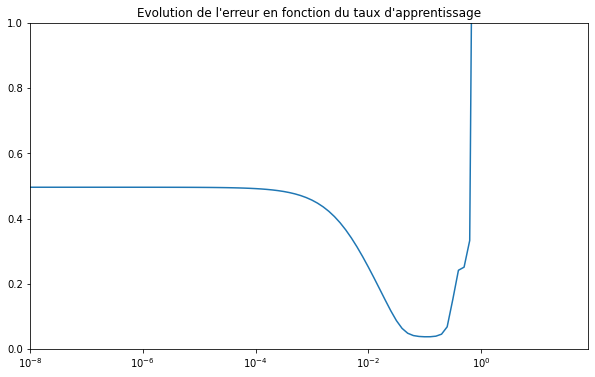

In [348]:
# Construit un vecteur avec les valeurs du taux d'apprentissage à chaque période 
taux = 1e-8*(10**(np.arange(100)/10))

# Affiche l'erreur en fonction du taux d'apprentissage
plt.figure(figsize=(10, 6))
plt.semilogx(taux,historique.history["loss"])
plt.axis([ taux[0], taux[99], 0, 1])
plt.title("Evolution de l'erreur en fonction du taux d'apprentissage")

In [349]:
# Chargement des poids sauvegardés
model.load_weights("poids.hdf5")

In [376]:
max_periodes = 1000

# Classe permettant d'arrêter l'entrainement si la variation
# devient plus petite qu'une valeur à choisir sur un nombre
# de périodes à choisir
class StopTrain(keras.callbacks.Callback):
    def __init__(self, delta=0.01,periodes=100, term="loss", logs={}):
      self.n_periodes = 0
      self.periodes = periodes
      self.loss_1 = 100
      self.delta = delta
      self.term = term
    def on_epoch_end(self, epoch, logs={}):
      diff_loss = abs(self.loss_1 - logs[self.term])
      self.loss_1 = logs[self.term]
      if (diff_loss < self.delta):
        self.n_periodes = self.n_periodes + 1
      else:
        self.n_periodes = 0
      if (self.n_periodes == self.periodes):
        print("Arrêt de l'entrainement...")
        self.model.stop_training = True

# Définition des paramètres liés à l'évolution du taux d'apprentissage
lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
    initial_learning_rate=0.1,
    decay_steps=10,
    decay_rate=0.01)

# Définition de l'optimiseur à utiliser
optimiseur=tf.keras.optimizers.SGD(learning_rate=lr_schedule,momentum=0.9)

# Utilisation de la méthode ModelCheckPoint
CheckPoint = tf.keras.callbacks.ModelCheckpoint("poids_train.hdf5", monitor='loss', verbose=1, save_best_only=True, save_weights_only = True, mode='auto', save_freq='epoch')

# Compile le modèle
model.compile(loss="mse", optimizer=optimiseur, metrics=["mse"])

# Entraine le modèle, avec une réduction des calculs du gradient
#historique = model.fit(x=x_train,y=y_train,validation_data=(x_val,y_val), epochs=max_periodes,verbose=1, callbacks=[CheckPoint,StopTrain(delta=1e-7,periodes = 10, term="My_MSE")],batch_size=batch_size)

# Entraine le modèle sans réduction de calculs
historique = model.fit(dataset,validation_data=dataset_val, epochs=max_periodes,verbose=1, callbacks=[CheckPoint,StopTrain(delta=1e-8,periodes = 10, term="loss")])
#historique = model.fit(dataset, epochs=max_periodes)


Epoch 1/1000
160/160 [==============================] - 2s 8ms/step - loss: 0.0298 - mse: 0.0298

Epoch 00001: loss improved from inf to 0.02374, saving model to poids_train.hdf5
Epoch 2/1000
160/160 [==============================] - 1s 6ms/step - loss: 0.1093 - mse: 0.1093

Epoch 00002: loss did not improve from 0.02374
Epoch 3/1000
160/160 [==============================] - 1s 6ms/step - loss: 0.2120 - mse: 0.2120

Epoch 00003: loss did not improve from 0.02374
Epoch 4/1000
160/160 [==============================] - 1s 6ms/step - loss: 0.1721 - mse: 0.1721

Epoch 00004: loss did not improve from 0.02374
Epoch 5/1000
160/160 [==============================] - 1s 6ms/step - loss: 0.3180 - mse: 0.3180

Epoch 00005: loss did not improve from 0.02374
Epoch 6/1000
160/160 [==============================] - 1s 6ms/step - loss: 0.1737 - mse: 0.1737

Epoch 00006: loss did not improve from 0.02374
Epoch 7/1000
160/160 [==============================] - 1s 6ms/step - loss: 0.1822 - mse: 0.1822

KeyboardInterrupt: ignored

In [377]:
model.load_weights("poids_train.hdf5")

Text(0.5, 1.0, "Evolution de l'erreur en fonction de la période")

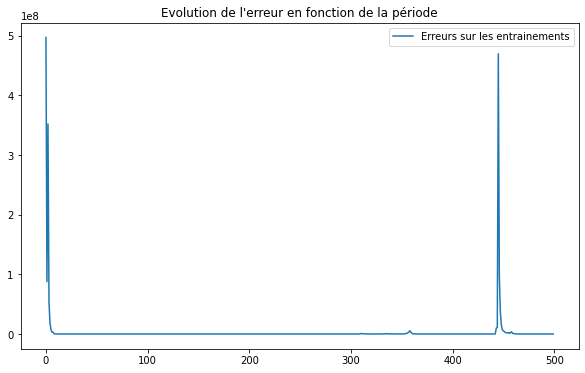

In [335]:
erreur_entrainement = historique.history["loss"]
#erreur_validation = historique.history["val_loss"]

# Affiche l'erreur en fonction de la période
plt.figure(figsize=(10, 6))
plt.plot(np.arange(0,len(erreur_entrainement)),erreur_entrainement, label="Erreurs sur les entrainements")
#plt.plot(np.arange(0,len(erreur_entrainement)),erreur_validation, label ="Erreurs sur les validations")
plt.legend()

plt.title("Evolution de l'erreur en fonction de la période")

In [353]:
# Evaluation du modèle

model.evaluate(dataset)
#model.evaluate(dataset_val)


4/4 [==============================] - 0s 12ms/step - loss: 0.0035 - mse: 0.0035


[0.0035034799948334694, 0.0035034799948334694]

**3. Prédictions**

In [354]:
# Création des instants d'entrainement et de validation
y_train_timing = serie_entrainement.index[taille_fenetre + horizon - 1:taille_fenetre + horizon - 1+len(y_train)]
y_val_timing = serie_test.index[taille_fenetre + horizon - 1:taille_fenetre + horizon - 1+len(y_val)]

# Calcul des prédictions
pred_ent = model.predict(x_train, verbose=1)
pred_val = model.predict(x_val, verbose=1)

8/8 [==============================] - 0s 3ms/step


ValueError: ignored

In [379]:
from statsmodels.tsa.statespace.tools import diff

predictions=[]

for t in range(0,serie_entrainement.size-taille_fenetre):
  data_to_predict = serie_entrainement[t:t+taille_fenetre]

  data_to_predict = tf.expand_dims(data_to_predict,axis=1)
  data_to_predict = tf.expand_dims(data_to_predict,axis=0)
  pred = model.predict(data_to_predict)
  predictions.append(pred[0])

In [380]:
import plotly.graph_objects as go

fig = go.Figure()

tmax = len(np.asarray(predictions)[:,0])

# Courbes des prédictions d'entrainement
#fig.add_trace(go.Scatter(x=serie_etude.index,y=data_to_predict[:,:,0][0],line=dict(color='green', width=1),name="data_to_predict"))
fig.add_trace(go.Scatter(x=df_paris.index[taille_fenetre:taille_fenetre+tmax],y=np.asarray(predictions)[:,0],line=dict(color='red', width=1),name="prediction"))

fig.add_trace(go.Scatter(x=df_paris.index[taille_fenetre:taille_fenetre+tmax],y=serie_entrainement[taille_fenetre:taille_fenetre+tmax],line=dict(color='black', width=1),name="true"))




fig.update_xaxes(rangeslider_visible=True)
yaxis=dict(autorange = True,fixedrange= False)
fig.update_yaxes(yaxis)
fig.show()

**4.Affichage sur une période de 1 heure**

Création d'une série contenant les valeurs originales et les prédictions, synchronisées dans le temps :

In [ ]:
serie_btc_ent_ori = serie_entrainement*std+mean
serie_btc_val_ori = serie_test*std+mean

serie_btc_ent_pred = pd.Series(data=(pred_ent[:,0]*std+mean),index=y_train_timing)
serie_btc_val_pred = pd.Series(data=(pred_val[:,0]*std+mean),index=y_val_timing)

serie_btc_ori = pd.concat([serie_btc_ent_ori,serie_btc_val_ori])
serie_btc_pred = pd.concat([serie_btc_ent_pred,serie_btc_val_pred])

serie_btc_ori = serie_btc_ori.fillna(method="backfill")
serie_btc_pred = serie_btc_pred.fillna(method="backfill")

serie_btc_ent_ori = serie_btc_ent_ori.fillna(method="backfill")
serie_btc_val_ori = serie_btc_val_ori.fillna(method="backfill")
serie_btc_ent_pred = serie_btc_ent_pred.fillna(method="backfill")
serie_btc_val_pred = serie_btc_val_pred.fillna(method="backfill")

frame = {'BTC_ALL' : serie_btc_ori, 'BTC_ENT': serie_btc_ent_ori, 'BTC_VAL' : serie_btc_val_ori, 'BTC_PRED' : serie_btc_pred, 'BTC_PRED_ENT' : serie_btc_ent_pred, 'BTC_PRED_VAL':serie_btc_val_pred}
df_resultats = pd.DataFrame(frame)
df_resultats

In [ ]:
import plotly.graph_objects as go

fig = go.Figure()

# Courbe originale
fig.add_trace(go.Scatter(x=df_resultats.index,y=df_resultats['BTC_ALL'],line=dict(color='blue', width=1),name="Prix BTC"))

# Courbes des prédictions d'entrainement
fig.add_trace(go.Scatter(x=df_resultats.index,y=df_resultats['BTC_PRED_ENT'],line=dict(color='green', width=1),name="Entrainement"))

# Courbe de validation
fig.add_trace(go.Scatter(x=df_resultats.index,y=df_resultats['BTC_PRED_VAL'],line=dict(color='red', width=1),name="Validation"))

fig.update_xaxes(rangeslider_visible=True)
yaxis=dict(autorange = True,fixedrange= False)
fig.update_yaxes(yaxis)
fig.show()

In [ ]:
serie_etude

In [ ]:
from scipy.special import inv_boxcox

In [ ]:
from scipy.integrate import cumtrapz
import numpy as np
import matplotlib.pyplot as plt

def f(x):
    return serie_etude['Open'][0:taille_fenetre+1]

f = np.vectorize(f)

X = np.linspace(0,taille_fenetre+1,taille_fenetre+2)

fv = f(X)
plt.plot(fv)

F = cumtrapz(fv, x=X, initial=0)
plt.plot(F);

In [ ]:
from statsmodels.tsa.statespace.tools import diff

predictions=[]

for t in range(0,200):
  data_to_predict = serie_etude['Open'][t:t+taille_fenetre+1]
  data_to_predict = boxcox(data_to_predict,lam)
  data_to_predict = data_to_predict - trend[t:t+taille_fenetre+1]
  data_to_predict = diff(data_to_predict,1)
  data_to_predict = np.insert(data_to_predict,0,0)

  data_to_predict = tf.expand_dims(data_to_predict,axis=1)
  data_to_predict = tf.expand_dims(data_to_predict,axis=0)
  pred = model.predict(data_to_predict[:,1:,:])
  predictions.append(pred[0])

In [ ]:
np.asarray(predictions)[:,0]

In [ ]:
serie_etude.index[taille_fenetre+1:taille_fenetre+2]

In [ ]:
import plotly.graph_objects as go

fig = go.Figure()

tmax = len(np.asarray(predictions)[:,0])

# Courbe originale
fig.add_trace(go.Scatter(x=serie_etude.index,y=serie_etude['diff'][0:taille_fenetre+1],line=dict(color='blue', width=1),name="diff_reel"))

# Courbes des prédictions d'entrainement
#fig.add_trace(go.Scatter(x=serie_etude.index,y=data_to_predict[:,:,0][0],line=dict(color='green', width=1),name="data_to_predict"))
fig.add_trace(go.Scatter(x=serie_etude.index[taille_fenetre+1:taille_fenetre+1+tmax],y=np.asarray(predictions)[:,0],line=dict(color='red', width=1),name="prediction"))

fig.add_trace(go.Scatter(x=serie_etude.index[taille_fenetre+1:taille_fenetre+1+tmax],y=serie_etude['diff'][taille_fenetre+1:taille_fenetre+1+tmax],line=dict(color='black', width=1),name="true"))




fig.update_xaxes(rangeslider_visible=True)
yaxis=dict(autorange = True,fixedrange= False)
fig.update_yaxes(yaxis)
fig.show()

# Création du modèle LSTM

**1. Création du réseau**

Par défaut, la dimension des vecteurs cachés est de 10 et aucune régularisation n'est utilisée.

In [ ]:
dim_LSTM = 40
l1_reg = 0.0
l2_reg = 0.0

entrees = tf.keras.layers.Input(shape=(taille_fenetre,1))

# Encodeur
s_encodeur = tf.keras.layers.LSTM(dim_LSTM, kernel_regularizer=tf.keras.regularizers.l1_l2(l1=l1_reg,l2=l2_reg))(entrees)
  
# Générateur
sortie = tf.keras.layers.Dense(1,kernel_regularizer=tf.keras.regularizers.l1_l2(l1=l1_reg,l2=l2_reg))(s_encodeur)

# Construction du modèle
model = tf.keras.Model(entrees,sortie)
model.summary()

**2. Optimisation de l'apprentissage**

Pour accélérer le traitement des données, nous n'allons pas utiliser l'intégralité des données pendant la mise à jour du gradient, comme cela a été fait jusqu'à présent (en utilisant le dataset).  
Cette fois-ci, nous allons forcer les mises à jour du gradient à se produire de manière moins fréquente en attribuant la valeur du batch_size à prendre en compte lors de la regression du modèle.  
Pour cela, on utilise l'argument "batch_size" dans la méthode fit. En précisant un batch_size=1000, cela signifie que :
 - Sur notre total de 56000 échantillons, 56 seront utilisés pour les calculs du gradient
 - Il y aura également 56 itérations à chaque période.
  
    
    
Si nous avions pris le dataset comme entrée, nous aurions eu :
- Un total de 56000 échantillons également
- Chaque période aurait également pris 56 itérations pour se compléter
- Mais 1000 échantillons auraient été utilisés pour le calcul du gradient, au lieu de 56 avec la méthode utilisée.

In [ ]:
batch_size = 1000

In [ ]:
# Définition de la fonction de régulation du taux d'apprentissage
def RegulationTauxApprentissage(periode, taux):
  return 1e-8*10**(periode/10)

# Définition de l'optimiseur à utiliser
optimiseur=tf.keras.optimizers.Adam()

# Compile le modèle
model.compile(loss="logcosh", optimizer=optimiseur, metrics="mse")

# Utilisation de la méthode ModelCheckPoint
CheckPoint = tf.keras.callbacks.ModelCheckpoint("poids.hdf5", monitor='loss', verbose=1, save_best_only=True, save_weights_only = True, mode='auto', save_freq='epoch')

# Entraine le modèle en utilisant notre fonction personnelle de régulation du taux d'apprentissage
historique = model.fit(x=x_train,y=y_train,epochs=100,verbose=1, callbacks=[tf.keras.callbacks.LearningRateScheduler(RegulationTauxApprentissage), CheckPoint],batch_size=batch_size)

In [ ]:
# Construit un vecteur avec les valeurs du taux d'apprentissage à chaque période 
taux = 1e-8*(10**(np.arange(100)/10))

# Affiche l'erreur en fonction du taux d'apprentissage
plt.figure(figsize=(10, 6))
plt.semilogx(taux,historique.history["loss"])
plt.axis([ taux[30], taux[99], 0, 0.04])
plt.title("Evolution de l'erreur en fonction du taux d'apprentissage")

In [ ]:
# Chargement des poids sauvegardés
model.load_weights("poids.hdf5")

In [ ]:
max_periodes = 1000

# Classe permettant d'arrêter l'entrainement si la variation
# devient plus petite qu'une valeur à choisir sur un nombre
# de périodes à choisir
class StopTrain(keras.callbacks.Callback):
    def __init__(self, delta=0.01,periodes=100, term="loss", logs={}):
      self.n_periodes = 0
      self.periodes = periodes
      self.loss_1 = 100
      self.delta = delta
      self.term = term
    def on_epoch_end(self, epoch, logs={}):
      diff_loss = abs(self.loss_1 - logs[self.term])
      self.loss_1 = logs[self.term]
      if (diff_loss < self.delta):
        self.n_periodes = self.n_periodes + 1
      else:
        self.n_periodes = 0
      if (self.n_periodes == self.periodes):
        print("Arrêt de l'entrainement...")
        self.model.stop_training = True

def  My_MSE(y_true,y_pred):
  return(tf.keras.metrics.mse(y_true,y_pred)*std.numpy()+mean.numpy())
  
# Définition des paramètres liés à l'évolution du taux d'apprentissage
lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
    initial_learning_rate=0.02,
    decay_steps=10,
    decay_rate=0.01)

# Définition de l'optimiseur à utiliser
optimiseur=tf.keras.optimizers.Adam(learning_rate=lr_schedule)


# Utilisation de la méthode ModelCheckPoint
CheckPoint = tf.keras.callbacks.ModelCheckpoint("poids_train.hdf5", monitor='loss', verbose=1, save_best_only=True, save_weights_only = True, mode='auto', save_freq='epoch')

# Compile le modèle
model.compile(loss="logcosh", optimizer=optimiseur, metrics=["mse",My_MSE])

# Entraine le modèle, avec une réduction des calculs du gradient
historique = model.fit(x=x_train,y=y_train,validation_data=(x_val,y_val), epochs=max_periodes,verbose=1, callbacks=[CheckPoint,StopTrain(delta=0.005,periodes = 10, term="My_MSE")],batch_size=batch_size)

# Entraine le modèle sans réduction de calculs
#historique = model.fit(dataset,validation_data=dataset_val, epochs=max_periodes,verbose=1, callbacks=[CheckPoint,StopTrain(delta=0.1,periodes = 10, term="val_My_MSE")])


In [ ]:
erreur_entrainement = historique.history["loss"]
erreur_validation = historique.history["val_loss"]

# Affiche l'erreur en fonction de la période
plt.figure(figsize=(10, 6))
plt.plot(np.arange(0,len(erreur_entrainement)),erreur_entrainement, label="Erreurs sur les entrainements")
plt.plot(np.arange(0,len(erreur_entrainement)),erreur_validation, label ="Erreurs sur les validations")
plt.legend()

plt.title("Evolution de l'erreur en fonction de la période")

In [ ]:
# Evaluation du modèle
# Avec le modèle type encodeur/décodeur :
# 56/56 [==============================] - 7s 113ms/step - loss: 1.1795e-04 - mse: 2.3664e-04 - My_MSE: 2712.2415
# 14/14 [==============================] - 2s 113ms/step - loss: 0.3602 - mse: 1.9360 - My_MSE: 9650.2637
model.evaluate(dataset)
model.evaluate(dataset_val)


**3. Prédictions**

In [ ]:
# Création des instants d'entrainement et de validation
y_train_timing = serie_entrainement.index[taille_fenetre + horizon - 1:taille_fenetre + horizon - 1+len(y_train)]
y_val_timing = serie_test.index[taille_fenetre + horizon - 1:taille_fenetre + horizon - 1+len(y_val)]

# Calcul des prédictions
pred_ent = model.predict(x_train, verbose=1)
pred_val = model.predict(x_val, verbose=1)

**4.Affichage sur une période de 1 heure**

Création d'une série contenant les valeurs originales et les prédictions, synchronisées dans le temps :

In [ ]:
serie_btc_ent_ori = serie_entrainement*std+mean
serie_btc_val_ori = serie_test*std+mean

serie_btc_ent_pred = pd.Series(data=(pred_ent[:,0]*std+mean),index=y_train_timing)
serie_btc_val_pred = pd.Series(data=(pred_val[:,0]*std+mean),index=y_val_timing)

serie_btc_ori = pd.concat([serie_btc_ent_ori,serie_btc_val_ori])
serie_btc_pred = pd.concat([serie_btc_ent_pred,serie_btc_val_pred])

serie_btc_ori = serie_btc_ori.fillna(method="backfill")
serie_btc_pred = serie_btc_pred.fillna(method="backfill")

serie_btc_ent_ori = serie_btc_ent_ori.fillna(method="backfill")
serie_btc_val_ori = serie_btc_val_ori.fillna(method="backfill")
serie_btc_ent_pred = serie_btc_ent_pred.fillna(method="backfill")
serie_btc_val_pred = serie_btc_val_pred.fillna(method="backfill")

frame = {'BTC_ALL' : serie_btc_ori, 'BTC_ENT': serie_btc_ent_ori, 'BTC_VAL' : serie_btc_val_ori, 'BTC_PRED' : serie_btc_pred, 'BTC_PRED_ENT' : serie_btc_ent_pred, 'BTC_PRED_VAL':serie_btc_val_pred}
df_resultats = pd.DataFrame(frame)
df_resultats

In [ ]:
date_separation

In [ ]:
df_resultats.loc[date_separation-pd.Timedelta(hours=7):date_separation+pd.Timedelta(hours=7)]

In [ ]:
import plotly.graph_objects as go

fig = go.Figure()

# Courbe originale
fig.add_trace(go.Scatter(x=df_resultats.index,y=df_resultats['BTC_ALL'],line=dict(color='blue', width=1),name="Prix BTC"))

# Courbes des prédictions d'entrainement
fig.add_trace(go.Scatter(x=df_resultats.index,y=df_resultats['BTC_PRED_ENT'],line=dict(color='green', width=1),name="Entrainement"))

# Courbe de validation
fig.add_trace(go.Scatter(x=df_resultats.index,y=df_resultats['BTC_PRED_VAL'],line=dict(color='red', width=1),name="Validation"))

fig.update_xaxes(rangeslider_visible=True)
yaxis=dict(autorange = True,fixedrange= False)
fig.update_yaxes(yaxis)
fig.show()

**5. Détection de l'augmentation des erreurs dans la zone de validation**

On peut imaginer devoir suivre en temps réel l'évolution des prédictions afin de détecter lorsque le modèle n'est plus valide.

In [ ]:
# Détection de la date où commencent les anomalies
# sur la période de validation

# Construit les dataframe pour calculer les erreurs
df_error_btc_ent = df_resultats[['BTC_ENT','BTC_PRED_ENT']].dropna()
df_error_btc_val = df_resultats[['BTC_VAL','BTC_PRED_VAL']].dropna()

# Calcul des erreurs relatives sur les entrainements et les validations
erreur_ent = abs(np.asarray(df_error_btc_ent['BTC_ENT']) - np.asarray(df_error_btc_ent['BTC_PRED_ENT']))/np.asarray(df_error_btc_ent['BTC_ENT'])*100.0
erreur_val = abs(np.asarray(df_error_btc_val['BTC_VAL']) - np.asarray(df_error_btc_val['BTC_PRED_VAL']))/np.asarray(df_error_btc_val['BTC_VAL'])*100.0

# Erreur relative moyenne sur les entrainements
erreur_ent_mape = tf.keras.metrics.mape(np.asarray(df_error_btc_ent['BTC_ENT']),np.asarray(df_error_btc_ent['BTC_PRED_ENT']))
erreur_ent_mape_max = np.amax(erreur_ent)

# Calcul le nombre d'anomalies sur les entrainements avec le ratio spécifié
nbr_anomalies_ent = np.count_nonzero(erreur_ent>erreur_ent_mape)

# Calcul du ratio d'anomalies sur la période d'entrainement
ratio_ent = np.count_nonzero(erreur_ent>erreur_ent_mape)/erreur_ent.size

# Recherche de la date à partir de laquelle on dépasse l
n_erreurs = 0
for i in range(5,erreur_val.size):
  erreur_val_ = abs(np.asarray(df_error_btc_val['BTC_VAL'][i]) - np.asarray(df_error_btc_val['BTC_PRED_VAL'][i]))/np.asarray(df_error_btc_val['BTC_VAL'][i])*100.0
  seuil = erreur_ent_mape_max*1
  if erreur_val_ > seuil:
    n_erreurs = n_erreurs + 1
    if n_erreurs == 5:
      index = df_error_btc_val.index[i]
      break
  else:
    n_erreurs = 0
print(index)

In [ ]:
import plotly.graph_objects as go

fig = go.Figure()

# Courbe originale
fig.add_trace(go.Scatter(x=df_resultats.index,y=df_resultats['BTC_ALL'],line=dict(color='blue', width=1),name="Prix BTC"))

# Courbes des prédictions d'entrainement
fig.add_trace(go.Scatter(x=df_resultats.index,y=df_resultats['BTC_PRED_ENT'],line=dict(color='green', width=1),name="Entrainement"))

# Courbe de validation
fig.add_trace(go.Scatter(x=df_resultats.index,y=df_resultats['BTC_PRED_VAL'],line=dict(color='red', width=1),name="Validation"))

# Délimite la zone d'erreur
fig.add_shape(type="line",x0=index,y0=0,x1=index,y1=np.amax(df_resultats['BTC_ALL']),name="Zone d'erreur")

# Affiche les courbes
fig.update_xaxes(rangeslider_visible=True)
yaxis=dict(autorange = True,fixedrange= False)
fig.update_yaxes(yaxis)
fig.show()

**5.Affichage sur une période de 1 jour**

In [ ]:
# Echantillonage des données
time = "1D"

df_resultats = df_resultats.resample(time).asfreq()
df_resultats

In [ ]:
import plotly.graph_objects as go

fig = go.Figure()

# Courbe originale
fig.add_trace(go.Scatter(x=df_resultats.index,y=df_resultats['BTC_ALL'],line=dict(color='blue', width=1),name="Prix BTC"))

# Courbes des prédictions d'entrainement
fig.add_trace(go.Scatter(x=df_resultats.index,y=df_resultats['BTC_PRED_ENT'],line=dict(color='green', width=1),name="Entrainement"))

# Courbe de validation
fig.add_trace(go.Scatter(x=df_resultats.index,y=df_resultats['BTC_PRED_VAL'],line=dict(color='red', width=1),name="Validation"))

# Délimite la zone d'erreur
fig.add_shape(type="line",x0=index,y0=0,x1=index,y1=np.amax(df_resultats['BTC_ALL']),name="Zone d'erreur")

# Affiche les courbes
fig.update_xaxes(rangeslider_visible=True)
yaxis=dict(autorange = True,fixedrange= False)
fig.update_yaxes(yaxis)
fig.show()

**6.Synthèse des erreurs sur les différentes zones**

In [ ]:
# Echantillonage des données
time = "1H"

df_resultats = df_resultats.resample(time).asfreq()
df_resultats

In [ ]:
# Détection de la date où commencnte les anomalies
# sur la période de validation

# Construit les dataframe pour calculer les erreurs
df_error_btc_ent = df_resultats[['BTC_ENT','BTC_PRED_ENT']].dropna()
df_error_btc_val = df_resultats[['BTC_VAL','BTC_PRED_VAL']].dropna()


In [ ]:
# Erreurs d'entrainement
mae_ent = tf.keras.metrics.mean_absolute_error(np.asarray(df_error_btc_ent['BTC_ENT']),np.asarray(df_error_btc_ent['BTC_PRED_ENT'])).numpy()
mse_ent = tf.keras.metrics.mean_squared_error(np.asarray(df_error_btc_ent['BTC_ENT']),np.asarray(df_error_btc_ent['BTC_PRED_ENT'])).numpy()
mape_ent = tf.keras.metrics.mape(np.asarray(df_error_btc_ent['BTC_ENT']),np.asarray(df_error_btc_ent['BTC_PRED_ENT'])).numpy()

# Erreurs de validation
mae_val = tf.keras.metrics.mean_absolute_error(np.asarray(df_error_btc_val['BTC_VAL']),np.asarray(df_error_btc_val['BTC_PRED_VAL'])).numpy()
mse_val = tf.keras.metrics.mean_squared_error(np.asarray(df_error_btc_val['BTC_VAL']),np.asarray(df_error_btc_val['BTC_PRED_VAL'])).numpy()
mape_val = tf.keras.metrics.mape(np.asarray(df_error_btc_val['BTC_VAL']),np.asarray(df_error_btc_val['BTC_PRED_VAL'])).numpy()

# Erreurs sur la zone valide de validation
mae_val_ok = tf.keras.metrics.mean_absolute_error(df_error_btc_val['BTC_VAL'][:index],np.asarray(df_error_btc_val['BTC_PRED_VAL'][:index])).numpy()
mse_val_ok = tf.keras.metrics.mean_squared_error(df_error_btc_val['BTC_VAL'][:index],np.asarray(df_error_btc_val['BTC_PRED_VAL'][:index])).numpy()
mape_val_ok = tf.keras.metrics.mape(df_error_btc_val['BTC_VAL'][:index],np.asarray(df_error_btc_val['BTC_PRED_VAL'][:index])).numpy()


print("Erreur mae entrainement %s" %mae_ent)
print("Erreur mse entrainement : %s" %mse_ent)
print("Erreur mape entrainement : %s\n" %mape_ent)

print("Erreur mae validation %s" %mae_val)
print("Erreur mse validation : %s" %mse_val)
print("Erreur mape entrainement : %s\n" %mape_val)

print("Erreur mae validation zone OK %s" %mae_val_ok)
print("Erreur mse validation zone OK: %s" %mse_val_ok)
print("Erreur mape validation zone OK: %s" %mape_val_ok)

# Création du modèle LSTM avec auto-attention

**1. Création du réseau**

Par défaut, la dimension des vecteurs cachés est de 10 et aucune régularisation n'est utilisée.

In [ ]:
# Classe d'auto-attention
# Applique les poids de la matrice d'attention sur les vecteurs de la couche récurrente

# Importe le Backend de Keras
from keras import backend as K

# Définit une nouvelle classe Couche_Attention
# Héritée de la classe Layer de Keras

class Couche_Auto_Attention(tf.keras.layers.Layer):
  # Fonction d'initialisation de la classe d'attention
  def __init__(self,dim_att,nbr_hop):
    self.dim_att = dim_att          # Dimension du vecteur d'attention
    self.nbr_hop = nbr_hop
    super().__init__()              # Appel du __init__() de la classe Layer
  
  def build(self,input_shape):
    self.W = self.add_weight(shape=(self.dim_att,input_shape[2]),initializer='glorot_uniform',name="W")
    self.U = self.add_weight(shape=(self.nbr_hop,self.dim_att),initializer='glorot_uniform',name="U")
    super().build(input_shape)        # Appel de la méthode build()

  # Définit la logique de la couche d'attention
  # Arguments :   x : Tenseur d'entrée de dimension (None, nbr_v,dim)
  def call(self,x):
    # Calcul de la matrice XH contenant les
    # représentations cachées des vecteurs
    # issus de la couche GRU
    xt = tf.transpose(x,perm=[0,2,1])           # (None,20,40) => (None,40,20)
    Xh = tf.matmul(self.W,xt)                   # (#Att,40)x(None,40,20) = (None,#Att,20)
    Xh = K.tanh(Xh)                             # Xh = (None,#Att,20)

    # Calcul de la matrice des poids d'attention normalisés
    A = tf.matmul(self.U,Xh)                    # (#hop,#Att)x(None,#Att,20) = (None,#Att,20)
    A = tf.keras.activations.softmax(A,axis=2)  # (None,#Att,20)

    # Calcul de la matrice des vecteur d'attentions
    sortie = tf.matmul(A,x)                     # (None,#Att,20)x(None,20,40) = (None,#Att,40)
    return tf.keras.layers.Flatten()(sortie)

In [ ]:
dim_LSTM = 100
l1_reg = 0.0
l2_reg = 0.00
nbr_hop = 20

# Définition de l'entrée du modèle
entrees = tf.keras.layers.Input(shape=(taille_fenetre,1))

# Encodeur
s_encodeur = tf.keras.layers.LSTM(dim_LSTM,return_sequences=True,recurrent_regularizer=tf.keras.regularizers.l2(1e-5))(entrees)
s_attention = Couche_Auto_Attention(dim_att=dim_LSTM,nbr_hop=nbr_hop)(s_encodeur)

# Décodeur
s_decodeur = tf.keras.layers.Dense(dim_LSTM*nbr_hop,activation="tanh")(s_attention)
s_decodeur = tf.keras.layers.Concatenate()([s_decodeur,s_attention])

# Générateur
sortie = tf.keras.layers.Dense(1)(s_decodeur)

# Construction du modèle
model = tf.keras.Model(entrees,sortie)

model.summary()

**2. Optimisation de l'apprentissage**

Pour accélérer le traitement des données, nous n'allons pas utiliser l'intégralité des données pendant la mise à jour du gradient, comme cela a été fait jusqu'à présent (en utilisant le dataset).  
Cette fois-ci, nous allons forcer les mises à jour du gradient à se produire de manière moins fréquente en attribuant la valeur du batch_size à prendre en compte lors de la regression du modèle.  
Pour cela, on utilise l'argument "batch_size" dans la méthode fit. En précisant un batch_size=1000, cela signifie que :
 - Sur notre total de 56000 échantillons, 56 seront utilisés pour les calculs du gradient
 - Il y aura également 56 itérations à chaque période.
  
    
    
Si nous avions pris le dataset comme entrée, nous aurions eu :
- Un total de 56000 échantillons également
- Chaque période aurait également pris 56 itérations pour se compléter
- Mais 1000 échantillons auraient été utilisés pour le calcul du gradient, au lieu de 56 avec la méthode utilisée.

In [ ]:
batch_size = 1000

In [ ]:
# Définition de la fonction de régulation du taux d'apprentissage
def RegulationTauxApprentissage(periode, taux):
  return 1e-8*10**(periode/10)

# Définition de l'optimiseur à utiliser
optimiseur=tf.keras.optimizers.Adam()

# Compile le modèle
model.compile(loss="mse", optimizer=optimiseur, metrics="mse")

# Utilisation de la méthode ModelCheckPoint
CheckPoint = tf.keras.callbacks.ModelCheckpoint("poids.hdf5", monitor='loss', verbose=1, save_best_only=True, save_weights_only = True, mode='auto', save_freq='epoch')

# Entraine le modèle en utilisant notre fonction personnelle de régulation du taux d'apprentissage
historique = model.fit(x=x_train,y=y_train,epochs=100,verbose=1, callbacks=[tf.keras.callbacks.LearningRateScheduler(RegulationTauxApprentissage), CheckPoint],batch_size=batch_size)

In [ ]:
# Construit un vecteur avec les valeurs du taux d'apprentissage à chaque période 
taux = 1e-8*(10**(np.arange(100)/10))

# Affiche l'erreur en fonction du taux d'apprentissage
plt.figure(figsize=(10, 6))
plt.semilogx(taux,historique.history["loss"])
plt.axis([ taux[0], taux[99], 0, 2])
plt.title("Evolution de l'erreur en fonction du taux d'apprentissage")

In [ ]:
# Chargement des poids sauvegardés
model.load_weights("poids.hdf5")

In [ ]:
max_periodes = 1000

# Classe permettant d'arrêter l'entrainement si la variation
# devient plus petite qu'une valeur à choisir sur un nombre
# de périodes à choisir
class StopTrain(keras.callbacks.Callback):
    def __init__(self, delta=0.01,periodes=100, term="loss", logs={}):
      self.n_periodes = 0
      self.periodes = periodes
      self.loss_1 = 100
      self.delta = delta
      self.term = term
    def on_epoch_end(self, epoch, logs={}):
      diff_loss = abs(self.loss_1 - logs[self.term])
      self.loss_1 = logs[self.term]
      if (diff_loss < self.delta):
        self.n_periodes = self.n_periodes + 1
      else:
        self.n_periodes = 0
      if (self.n_periodes == self.periodes):
        print("Arrêt de l'entrainement...")
        self.model.stop_training = True

def  My_MSE(y_true,y_pred):
  return(tf.keras.metrics.mse(y_true,y_pred)*std.numpy()+mean.numpy())
  
# Définition des paramètres liés à l'évolution du taux d'apprentissage
lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
    initial_learning_rate=0.001,
    decay_steps=10,
    decay_rate=0.1)

# Définition de l'optimiseur à utiliser
optimiseur=tf.keras.optimizers.Adam(learning_rate=lr_schedule)


# Utilisation de la méthode ModelCheckPoint
CheckPoint = tf.keras.callbacks.ModelCheckpoint("poids_train.hdf5", monitor='loss', verbose=1, save_best_only=True, save_weights_only = True, mode='auto', save_freq='epoch')

# Compile le modèle
model.compile(loss="mse", optimizer=optimiseur, metrics=["mse",My_MSE])

# Entraine le modèle, avec une réduction des calculs du gradient
historique = model.fit(x=x_train,y=y_train,validation_data=(x_val,y_val), epochs=max_periodes,verbose=1, callbacks=[CheckPoint,StopTrain(delta=0.0005,periodes = 10, term="My_MSE")],batch_size=batch_size)

# Entraine le modèle sans réduction de calculs
#historique = model.fit(dataset,validation_data=dataset_val, epochs=max_periodes,verbose=1, callbacks=[CheckPoint,StopTrain(delta=0.1,periodes = 10, term="val_My_MSE")])


In [ ]:
model.load_weights('poids_train.hdf5')

In [ ]:
erreur_entrainement = historique.history["loss"]
erreur_validation = historique.history["val_loss"]

# Affiche l'erreur en fonction de la période
plt.figure(figsize=(10, 6))
plt.plot(np.arange(0,len(erreur_entrainement)),erreur_entrainement, label="Erreurs sur les entrainements")
plt.plot(np.arange(0,len(erreur_entrainement)),erreur_validation, label ="Erreurs sur les validations")
plt.legend()

plt.title("Evolution de l'erreur en fonction de la période")

In [ ]:
# Evaluation du modèle

model.evaluate(dataset)
model.evaluate(dataset_val)


**3. Prédictions**

In [ ]:
# Création des instants d'entrainement et de validation
y_train_timing = serie_entrainement_x.index[taille_fenetre + horizon - 1:taille_fenetre + horizon - 1+len(y_train)]
y_val_timing = serie_test_x.index[taille_fenetre + horizon - 1:taille_fenetre + horizon - 1+len(y_val)]

# Calcul des prédictions
pred_ent = model.predict(x_train, verbose=1)
pred_val = model.predict(x_val, verbose=1)

**4.Affichage sur une période de 1 heure**

Création d'une série contenant les valeurs originales et les prédictions, synchronisées dans le temps :

In [ ]:
serie_btc_ent_ori = serie_entrainement_y*std+mean
serie_btc_val_ori = serie_test_y*std+mean

serie_btc_ent_pred = pd.Series(data=(pred_ent[:,0]*std+mean),index=y_train_timing)
serie_btc_val_pred = pd.Series(data=(pred_val[:,0]*std+mean),index=y_val_timing)

serie_btc_ori = pd.concat([serie_btc_ent_ori,serie_btc_val_ori])
serie_btc_pred = pd.concat([serie_btc_ent_pred,serie_btc_val_pred])

serie_btc_ori = serie_btc_ori.fillna(method="backfill")
serie_btc_pred = serie_btc_pred.fillna(method="backfill")

serie_btc_ent_ori = serie_btc_ent_ori.fillna(method="backfill")
serie_btc_val_ori = serie_btc_val_ori.fillna(method="backfill")
serie_btc_ent_pred = serie_btc_ent_pred.fillna(method="backfill")
serie_btc_val_pred = serie_btc_val_pred.fillna(method="backfill")

frame = {'BTC_ALL' : serie_btc_ori, 'BTC_ENT': serie_btc_ent_ori, 'BTC_VAL' : serie_btc_val_ori, 'BTC_PRED' : serie_btc_pred, 'BTC_PRED_ENT' : serie_btc_ent_pred, 'BTC_PRED_VAL':serie_btc_val_pred}
df_resultats = pd.DataFrame(frame)
df_resultats

In [ ]:
date_separation

In [ ]:
df_resultats.loc[date_separation-pd.Timedelta(hours=7):date_separation+pd.Timedelta(hours=7)]

In [ ]:
import plotly.graph_objects as go

fig = go.Figure()

# Courbe originale
fig.add_trace(go.Scatter(x=df_resultats.index,y=df_resultats['BTC_ALL'],line=dict(color='blue', width=1),name="Prix BTC"))

# Courbes des prédictions d'entrainement
fig.add_trace(go.Scatter(x=df_resultats.index,y=df_resultats['BTC_PRED_ENT'],line=dict(color='green', width=1),name="Entrainement"))

# Courbe de validation
fig.add_trace(go.Scatter(x=df_resultats.index,y=df_resultats['BTC_PRED_VAL'],line=dict(color='red', width=1),name="Validation"))

fig.update_xaxes(rangeslider_visible=True)
yaxis=dict(autorange = True,fixedrange= False)
fig.update_yaxes(yaxis)
fig.show()

**5. Détection de l'augmentation des erreurs dans la zone de validation**

On peut imaginer devoir suivre en temps réel l'évolution des prédictions afin de détecter lorsque le modèle n'est plus valide.

In [ ]:
# Détection de la date où commencent les anomalies
# sur la période de validation

# Construit les dataframe pour calculer les erreurs
df_error_btc_ent = df_resultats[['BTC_ENT','BTC_PRED_ENT']].dropna()
df_error_btc_val = df_resultats[['BTC_VAL','BTC_PRED_VAL']].dropna()

# Calcul des erreurs relatives sur les entrainements et les validations
erreur_ent = abs(np.asarray(df_error_btc_ent['BTC_ENT']) - np.asarray(df_error_btc_ent['BTC_PRED_ENT']))/np.asarray(df_error_btc_ent['BTC_ENT'])*100.0
erreur_val = abs(np.asarray(df_error_btc_val['BTC_VAL']) - np.asarray(df_error_btc_val['BTC_PRED_VAL']))/np.asarray(df_error_btc_val['BTC_VAL'])*100.0

# Erreur relative moyenne sur les entrainements
erreur_ent_mape = tf.keras.metrics.mape(np.asarray(df_error_btc_ent['BTC_ENT']),np.asarray(df_error_btc_ent['BTC_PRED_ENT']))
erreur_ent_mape_max = np.amax(erreur_ent)

# Calcul le nombre d'anomalies sur les entrainements avec le ratio spécifié
nbr_anomalies_ent = np.count_nonzero(erreur_ent>erreur_ent_mape)

# Calcul du ratio d'anomalies sur la période d'entrainement
ratio_ent = np.count_nonzero(erreur_ent>erreur_ent_mape)/erreur_ent.size

# Recherche de la date à partir de laquelle on dépasse l
n_erreurs = 0
for i in range(5,erreur_val.size):
  erreur_val_ = abs(np.asarray(df_error_btc_val['BTC_VAL'][i]) - np.asarray(df_error_btc_val['BTC_PRED_VAL'][i]))/np.asarray(df_error_btc_val['BTC_VAL'][i])*100.0
  seuil = erreur_ent_mape_max*1
  if erreur_val_ > seuil:
    n_erreurs = n_erreurs + 1
    if n_erreurs == 1:
      index = df_error_btc_val.index[i]
      break
  else:
    n_erreurs = 0
print(index)


In [ ]:
import plotly.graph_objects as go

fig = go.Figure()

# Courbe originale
fig.add_trace(go.Scatter(x=df_resultats.index,y=df_resultats['BTC_ALL'],line=dict(color='blue', width=1),name="Prix BTC"))

# Courbes des prédictions d'entrainement
fig.add_trace(go.Scatter(x=df_resultats.index,y=df_resultats['BTC_PRED_ENT'],line=dict(color='green', width=1),name="Entrainement"))

# Courbe de validation
fig.add_trace(go.Scatter(x=df_resultats.index,y=df_resultats['BTC_PRED_VAL'],line=dict(color='red', width=1),name="Validation"))

# Délimite la zone d'erreur
fig.add_shape(type="line",x0=index,y0=0,x1=index,y1=np.amax(df_resultats['BTC_ALL']),name="Zone d'erreur")

# Affiche les courbes
fig.update_xaxes(rangeslider_visible=True)
yaxis=dict(autorange = True,fixedrange= False)
fig.update_yaxes(yaxis)
fig.show()

**5.Affichage sur une période de 1 jour**

In [ ]:
# Echantillonage des données
time = "1D"

df_resultats = df_resultats.resample(time).asfreq()
df_resultats

In [ ]:
import plotly.graph_objects as go

fig = go.Figure()

# Courbe originale
fig.add_trace(go.Scatter(x=df_resultats.index,y=df_resultats['BTC_ALL'],line=dict(color='blue', width=1),name="Prix BTC"))

# Courbes des prédictions d'entrainement
fig.add_trace(go.Scatter(x=df_resultats.index,y=df_resultats['BTC_PRED_ENT'],line=dict(color='green', width=1),name="Entrainement"))

# Courbe de validation
fig.add_trace(go.Scatter(x=df_resultats.index,y=df_resultats['BTC_PRED_VAL'],line=dict(color='red', width=1),name="Validation"))

# Délimite la zone d'erreur
fig.add_shape(type="line",x0=index,y0=0,x1=index,y1=np.amax(df_resultats['BTC_ALL']),name="Zone d'erreur")

# Affiche les courbes
fig.update_xaxes(rangeslider_visible=True)
yaxis=dict(autorange = True,fixedrange= False)
fig.update_yaxes(yaxis)
fig.show()

**6.Synthèse des erreurs sur les différentes zones**

In [ ]:
# Echantillonage des données
time = "1H"

df_resultats = df_resultats.resample(time).asfreq()
df_resultats

In [ ]:
# Détection de la date où commencnte les anomalies
# sur la période de validation

# Construit les dataframe pour calculer les erreurs
df_error_btc_ent = df_resultats[['BTC_ENT','BTC_PRED_ENT']].dropna()
df_error_btc_val = df_resultats[['BTC_VAL','BTC_PRED_VAL']].dropna()


In [ ]:
# Erreurs d'entrainement
mae_ent = tf.keras.metrics.mean_absolute_error(np.asarray(df_error_btc_ent['BTC_ENT']),np.asarray(df_error_btc_ent['BTC_PRED_ENT'])).numpy()
mse_ent = tf.keras.metrics.mean_squared_error(np.asarray(df_error_btc_ent['BTC_ENT']),np.asarray(df_error_btc_ent['BTC_PRED_ENT'])).numpy()
mape_ent = tf.keras.metrics.mape(np.asarray(df_error_btc_ent['BTC_ENT']),np.asarray(df_error_btc_ent['BTC_PRED_ENT'])).numpy()

# Erreurs de validation
mae_val = tf.keras.metrics.mean_absolute_error(np.asarray(df_error_btc_val['BTC_VAL']),np.asarray(df_error_btc_val['BTC_PRED_VAL'])).numpy()
mse_val = tf.keras.metrics.mean_squared_error(np.asarray(df_error_btc_val['BTC_VAL']),np.asarray(df_error_btc_val['BTC_PRED_VAL'])).numpy()
mape_val = tf.keras.metrics.mape(np.asarray(df_error_btc_val['BTC_VAL']),np.asarray(df_error_btc_val['BTC_PRED_VAL'])).numpy()

# Erreurs sur la zone valide de validation
mae_val_ok = tf.keras.metrics.mean_absolute_error(df_error_btc_val['BTC_VAL'][:index],np.asarray(df_error_btc_val['BTC_PRED_VAL'][:index])).numpy()
mse_val_ok = tf.keras.metrics.mean_squared_error(df_error_btc_val['BTC_VAL'][:index],np.asarray(df_error_btc_val['BTC_PRED_VAL'][:index])).numpy()
mape_val_ok = tf.keras.metrics.mape(df_error_btc_val['BTC_VAL'][:index],np.asarray(df_error_btc_val['BTC_PRED_VAL'][:index])).numpy()


print("Erreur mae entrainement %s" %mae_ent)
print("Erreur mse entrainement : %s" %mse_ent)
print("Erreur mape entrainement : %s\n" %mape_ent)

print("Erreur mae validation %s" %mae_val)
print("Erreur mse validation : %s" %mse_val)
print("Erreur mape entrainement : %s\n" %mape_val)

print("Erreur mae validation zone OK %s" %mae_val_ok)
print("Erreur mse validation zone OK: %s" %mse_val_ok)
print("Erreur mape validation zone OK: %s" %mape_val_ok)

# Création du modèle End-To-End Network

In [ ]:
def prepare_dataset_XY(serie, taille_fenetre, batch_size, nbr_sequences):
  dataset = tf.data.Dataset.from_tensor_slices(serie)
  dataset = dataset.window(taille_fenetre+1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda x: x.batch(taille_fenetre + 1))
  dataset = dataset.window(nbr_sequences+1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda x: x.batch(nbr_sequences+1,drop_remainder=True))
  dataset = dataset.map(lambda x: [(tf.slice(x,[0,0],[nbr_sequences,taille_fenetre]),                           # (30;20)       [((30,20),(20)),(1)]
                                   tf.squeeze(tf.slice(x,[nbr_sequences,0],[1,taille_fenetre]),axis=0)),        # (20)
                                   tf.squeeze(tf.slice(x,[nbr_sequences,taille_fenetre],[1,1]),axis=0)])        # (1)
  dataset = dataset.batch(batch_size,drop_remainder=True)
  return dataset

In [ ]:
# Définition des caractéristiques du dataset que l'on souhaite créer
taille_fenetre = 15
batch_size = 1000
Nbr_Sequences = 10

dataset = prepare_dataset_XY(serie_entrainement,taille_fenetre,batch_size,Nbr_Sequences)              # 56x((1000,10,15),(1000,15)),(1000,1)
dataset_val = prepare_dataset_XY(serie_test,taille_fenetre,batch_size,Nbr_Sequences)              # 56x((1000,10,15),(1000,15)),(1000,1)


In [ ]:
len(list(dataset.as_numpy_iterator()))

In [ ]:
for element in dataset.take(1):
  print(element)

In [ ]:
# Extrait les X,Y du dataset
#56x((1000,4,1),(1000,1)) => (56*1000,4,1) ; (56*1000,1)

x,y = tuple(zip(*dataset))

# Recombine les données
# (56,1000,4,1) => (56*128,4,1)
# (56,1000,1) => (56*128,1)
x_train = np.asarray(tf.reshape(np.asarray(x,dtype=np.float32),shape=(np.asarray(x).shape[0]*np.asarray(x).shape[1],taille_fenetre,1)))
y_train = np.asarray(tf.reshape(np.asarray(y,dtype=np.float32),shape=(np.asarray(y).shape[0]*np.asarray(y).shape[1])))

# Affiche les formats
print(x_train.shape)
print(y_train.shape)

**1. Création du réseau**

Par défaut, la dimension des vecteurs cachés est de 10 et aucune régularisation n'est utilisée.

In [ ]:
# Définition du de la couche du modèle
# End-to-End Memory Network
# Epaquetage des données avec le dernier état caché d'une couche GRU

from keras import backend as K

class Couche_End_to_End_MN(tf.keras.layers.Layer):
  # Fonction d'initialisation de la classe d'attention
  # dim_GRU : Dimension des vecteurs GRU
  # x : Séquences à mémoriser (batch_size, Nbr_Sequence, taille_fenetre)
  # Fonction de la couche lambda d'entrée
  def __init__(self,dim_GRU,regul=0.0):
    self.dim_GRU = dim_GRU
    self.regul = regul
    super().__init__()          # Appel du __init__() de la classe Layer
  
  def build(self,input_shape):
    # Définition des couches GRU pour traiter les séquences d'entrée
    self.couche_GRU_A = tf.keras.layers.GRU(self.dim_GRU,kernel_regularizer=tf.keras.regularizers.l2(self.regul))
    self.couche_GRU_B = tf.keras.layers.GRU(self.dim_GRU,kernel_regularizer=tf.keras.regularizers.l2(self.regul))
    self.couche_GRU_C = tf.keras.layers.GRU(self.dim_GRU,kernel_regularizer=tf.keras.regularizers.l2(self.regul))

    super().build(input_shape)        # Appel de la méthode build()

  # Définit la logique de la couche d'attention
  # Arguments :     x : (batch_size, Nbr_Sequence, taille_fenetre)
  #                 y : (batch_size, taille_fenetre)
  # Exemple :   batch_size = 32
  #             Nbr_Sequence =30
  #             taille_fenetre = 20
  #             dim_GRU = 40 
  def call(self,x,y):
    # Création des vecteurs mi dans le tenseur M
    M = tf.expand_dims(x,axis=-1)                                   # (32,30,20) => (32,30,20,1)
    M = tf.keras.layers.TimeDistributed(self.couche_GRU_A)(M)       # (32,30,20,1) => (32,30,40) : TimeStep = 30 : (32,20,1) envoyé
    M = K.tanh(M)

    # Création du vecteur d'état u
    u = tf.expand_dims(y,axis=-1)                                   # (32,20) => (32,20,1)
    u = self.couche_GRU_B(u)                                        # (32,20,1) => (32,40)
    u = tf.expand_dims(u,axis=-1)                                   # (32,40) => (32,40,1)
    u = K.tanh(u)                                                   # (32,40,1)

    # Calcul des poids d'attention
    p = tf.matmul(M,u)                                              # (32,30,40)x(32,40,1)=(32,30,1)
    p = tf.keras.activations.softmax(p,axis=1)                      # (32,30,1)

    # Création des vecteurs ci dans le tenseur C
    C = tf.expand_dims(x,axis=-1)                                   # (32,30,20) => (32,30,20,1)
    C = tf.keras.layers.TimeDistributed(self.couche_GRU_C)(C)       # (32,30,20,1) => (32,30,40) : TimeStep = 30 : (32,20,1) envoyé
    C = K.tanh(C)

    # Calcul du vecteur réponse issu de la mémoire
    o = tf.multiply(C,p)                                            # (32,30,40)_x_(32,30,1) = (32,30,40)
    o = K.sum(o, axis=1)                                            # (32,40)
    o = K.tanh(o)                                                   # (32,40)
    
    # Retourne le vecteur d'attention
    return (o+tf.squeeze(u,axis=2))


In [ ]:
dim_LSTM = 40
l1_reg = 0.0
l2_reg = 0.0

# Définition des entrées du modèle
entrees_sequences = tf.keras.layers.Input(shape=(Nbr_Sequences,taille_fenetre))
entrees_entrainement = tf.keras.layers.Input(shape=(taille_fenetre))

# Encodeur
s_encodeur = Couche_End_to_End_MN(dim_GRU=dim_LSTM,regul=0.0)(entrees_sequences,entrees_entrainement)

# Décodeur
s_decodeur = tf.keras.layers.Dense(dim_LSTM,activation="tanh")(s_encodeur)
s_decodeur = tf.keras.layers.Concatenate()([s_decodeur,s_encodeur])

# Générateur
sortie = tf.keras.layers.Dense(1)(s_decodeur)

# Construction du modèle
model = tf.keras.Model([entrees_sequences,entrees_entrainement],sortie)
model.summary()

**2. Optimisation de l'apprentissage**

Pour accélérer le traitement des données, nous n'allons pas utiliser l'intégralité des données pendant la mise à jour du gradient, comme cela a été fait jusqu'à présent (en utilisant le dataset).  
Cette fois-ci, nous allons forcer les mises à jour du gradient à se produire de manière moins fréquente en attribuant la valeur du batch_size à prendre en compte lors de la regression du modèle.  
Pour cela, on utilise l'argument "batch_size" dans la méthode fit. En précisant un batch_size=1000, cela signifie que :
 - Sur notre total de 56000 échantillons, 56 seront utilisés pour les calculs du gradient
 - Il y aura également 56 itérations à chaque période.
  
    
    
Si nous avions pris le dataset comme entrée, nous aurions eu :
- Un total de 56000 échantillons également
- Chaque période aurait également pris 56 itérations pour se compléter
- Mais 1000 échantillons auraient été utilisés pour le calcul du gradient, au lieu de 56 avec la méthode utilisée.

In [ ]:
batch_size = 1000

In [ ]:
# Définition de la fonction de régulation du taux d'apprentissage
def RegulationTauxApprentissage(periode, taux):
  return 1e-8*10**(periode/10)

# Définition de l'optimiseur à utiliser
optimiseur=tf.keras.optimizers.Adam()

# Compile le modèle
model.compile(loss="logcosh", optimizer=optimiseur, metrics="mse")

# Utilisation de la méthode ModelCheckPoint
CheckPoint = tf.keras.callbacks.ModelCheckpoint("poids.hdf5", monitor='loss', verbose=1, save_best_only=True, save_weights_only = True, mode='auto', save_freq='epoch')

# Entraine le modèle en utilisant notre fonction personnelle de régulation du taux d'apprentissage
historique = model.fit(dataset,epochs=100,verbose=1, callbacks=[tf.keras.callbacks.LearningRateScheduler(RegulationTauxApprentissage), CheckPoint],batch_size=batch_size)

In [ ]:
# Construit un vecteur avec les valeurs du taux d'apprentissage à chaque période 
taux = 1e-8*(10**(np.arange(100)/10))

# Affiche l'erreur en fonction du taux d'apprentissage
plt.figure(figsize=(10, 6))
plt.semilogx(taux,historique.history["loss"])
plt.axis([ taux[30], taux[99], 0, 0.04])
plt.title("Evolution de l'erreur en fonction du taux d'apprentissage")

In [ ]:
# Chargement des poids sauvegardés
model.load_weights("poids.hdf5")

In [ ]:
max_periodes = 1000

# Classe permettant d'arrêter l'entrainement si la variation
# devient plus petite qu'une valeur à choisir sur un nombre
# de périodes à choisir
class StopTrain(keras.callbacks.Callback):
    def __init__(self, delta=0.01,periodes=100, term="loss", logs={}):
      self.n_periodes = 0
      self.periodes = periodes
      self.loss_1 = 100
      self.delta = delta
      self.term = term
    def on_epoch_end(self, epoch, logs={}):
      diff_loss = abs(self.loss_1 - logs[self.term])
      self.loss_1 = logs[self.term]
      if (diff_loss < self.delta):
        self.n_periodes = self.n_periodes + 1
      else:
        self.n_periodes = 0
      if (self.n_periodes == self.periodes):
        print("Arrêt de l'entrainement...")
        self.model.stop_training = True

def  My_MSE(y_true,y_pred):
  return(tf.keras.metrics.mse(y_true,y_pred)*std.numpy()+mean.numpy())
  
# Définition des paramètres liés à l'évolution du taux d'apprentissage
lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
    initial_learning_rate=0.001,
    decay_steps=10,
    decay_rate=0.01)

# Définition de l'optimiseur à utiliser
optimiseur=tf.keras.optimizers.Adam(learning_rate=lr_schedule)


# Utilisation de la méthode ModelCheckPoint
CheckPoint = tf.keras.callbacks.ModelCheckpoint("poids_train.hdf5", monitor='loss', verbose=1, save_best_only=True, save_weights_only = True, mode='auto', save_freq='epoch')

# Compile le modèle
model.compile(loss="logcosh", optimizer=optimiseur, metrics=["mse",My_MSE])

# Entraine le modèle, avec une réduction des calculs du gradient
#historique = model.fit(x=x_train,y=y_train,validation_data=(x_val,y_val), epochs=max_periodes,verbose=1, callbacks=[CheckPoint,StopTrain(delta=0.005,periodes = 10, term="My_MSE")],batch_size=batch_size)

# Entraine le modèle sans réduction de calculs
historique = model.fit(dataset,validation_data=dataset_val, epochs=max_periodes,verbose=1, callbacks=[CheckPoint,StopTrain(delta=0.1,periodes = 10, term="val_My_MSE")])


In [ ]:
from google.colab import files
files.download('poids_train.hdf5')

In [ ]:
erreur_entrainement = historique.history["loss"]
erreur_validation = historique.history["val_loss"]

# Affiche l'erreur en fonction de la période
plt.figure(figsize=(10, 6))
plt.plot(np.arange(0,len(erreur_entrainement)),erreur_entrainement, label="Erreurs sur les entrainements")
plt.plot(np.arange(0,len(erreur_entrainement)),erreur_validation, label ="Erreurs sur les validations")
plt.legend()

plt.title("Evolution de l'erreur en fonction de la période")

In [ ]:
# Evaluation du modèle
# Avec le modèle type encodeur/décodeur :
# 56/56 [==============================] - 7s 113ms/step - loss: 1.1795e-04 - mse: 2.3664e-04 - My_MSE: 2712.2415
# 14/14 [==============================] - 2s 113ms/step - loss: 0.3602 - mse: 1.9360 - My_MSE: 9650.2637
model.evaluate(dataset)
model.evaluate(dataset_val)


**3. Prédictions**

In [ ]:
horizon = 1
# Création des instants d'entrainement et de validation
y_train_timing = serie_entrainement.index[taille_fenetre + horizon - 1:taille_fenetre + horizon - 1+len(y_train)]
y_val_timing = serie_test.index[taille_fenetre + horizon - 1:taille_fenetre + horizon - 1+len(y_val)]

# Calcul des prédictions
pred_ent = model.predict(x_train, verbose=1)
pred_val = model.predict(x_val, verbose=1)

**4.Affichage sur une période de 1 heure**

Création d'une série contenant les valeurs originales et les prédictions, synchronisées dans le temps :

In [ ]:
serie_btc_ent_ori = serie_entrainement*std+mean
serie_btc_val_ori = serie_test*std+mean

serie_btc_ent_pred = pd.Series(data=(pred_ent[:,0]*std+mean),index=y_train_timing)
serie_btc_val_pred = pd.Series(data=(pred_val[:,0]*std+mean),index=y_val_timing)

serie_btc_ori = pd.concat([serie_btc_ent_ori,serie_btc_val_ori])
serie_btc_pred = pd.concat([serie_btc_ent_pred,serie_btc_val_pred])

serie_btc_ori = serie_btc_ori.fillna(method="backfill")
serie_btc_pred = serie_btc_pred.fillna(method="backfill")

serie_btc_ent_ori = serie_btc_ent_ori.fillna(method="backfill")
serie_btc_val_ori = serie_btc_val_ori.fillna(method="backfill")
serie_btc_ent_pred = serie_btc_ent_pred.fillna(method="backfill")
serie_btc_val_pred = serie_btc_val_pred.fillna(method="backfill")

frame = {'BTC_ALL' : serie_btc_ori, 'BTC_ENT': serie_btc_ent_ori, 'BTC_VAL' : serie_btc_val_ori, 'BTC_PRED' : serie_btc_pred, 'BTC_PRED_ENT' : serie_btc_ent_pred, 'BTC_PRED_VAL':serie_btc_val_pred}
df_resultats = pd.DataFrame(frame)
df_resultats

In [ ]:
date_separation

In [ ]:
df_resultats.loc[date_separation-pd.Timedelta(hours=7):date_separation+pd.Timedelta(hours=7)]

In [ ]:
import plotly.graph_objects as go

fig = go.Figure()

# Courbe originale
fig.add_trace(go.Scatter(x=df_resultats.index,y=df_resultats['BTC_ALL'],line=dict(color='blue', width=1),name="Prix BTC"))

# Courbes des prédictions d'entrainement
fig.add_trace(go.Scatter(x=df_resultats.index,y=df_resultats['BTC_PRED_ENT'],line=dict(color='green', width=1),name="Entrainement"))

# Courbe de validation
fig.add_trace(go.Scatter(x=df_resultats.index,y=df_resultats['BTC_PRED_VAL'],line=dict(color='red', width=1),name="Validation"))

fig.update_xaxes(rangeslider_visible=True)
yaxis=dict(autorange = True,fixedrange= False)
fig.update_yaxes(yaxis)
fig.show()

**5. Détection de l'augmentation des erreurs dans la zone de validation**

On peut imaginer devoir suivre en temps réel l'évolution des prédictions afin de détecter lorsque le modèle n'est plus valide.

In [ ]:
# Détection de la date où commencent les anomalies
# sur la période de validation

# Construit les dataframe pour calculer les erreurs
df_error_btc_ent = df_resultats[['BTC_ENT','BTC_PRED_ENT']].dropna()
df_error_btc_val = df_resultats[['BTC_VAL','BTC_PRED_VAL']].dropna()

# Calcul des erreurs relatives sur les entrainements et les validations
erreur_ent = abs(np.asarray(df_error_btc_ent['BTC_ENT']) - np.asarray(df_error_btc_ent['BTC_PRED_ENT']))/np.asarray(df_error_btc_ent['BTC_ENT'])*100.0
erreur_val = abs(np.asarray(df_error_btc_val['BTC_VAL']) - np.asarray(df_error_btc_val['BTC_PRED_VAL']))/np.asarray(df_error_btc_val['BTC_VAL'])*100.0

# Erreur relative moyenne sur les entrainements
erreur_ent_mape = tf.keras.metrics.mape(np.asarray(df_error_btc_ent['BTC_ENT']),np.asarray(df_error_btc_ent['BTC_PRED_ENT']))
erreur_ent_mape_max = np.amax(erreur_ent)

# Calcul le nombre d'anomalies sur les entrainements avec le ratio spécifié
nbr_anomalies_ent = np.count_nonzero(erreur_ent>erreur_ent_mape)

# Calcul du ratio d'anomalies sur la période d'entrainement
ratio_ent = np.count_nonzero(erreur_ent>erreur_ent_mape)/erreur_ent.size

# Recherche de la date à partir de laquelle on dépasse l
n_erreurs = 0
for i in range(5,erreur_val.size):
  erreur_val_ = abs(np.asarray(df_error_btc_val['BTC_VAL'][i]) - np.asarray(df_error_btc_val['BTC_PRED_VAL'][i]))/np.asarray(df_error_btc_val['BTC_VAL'][i])*100.0
  seuil = erreur_ent_mape_max*1
  if erreur_val_ > seuil:
    n_erreurs = n_erreurs + 1
    if n_erreurs == 5:
      index = df_error_btc_val.index[i]
      break
  else:
    n_erreurs = 0
print(index)

In [ ]:
import plotly.graph_objects as go

fig = go.Figure()

# Courbe originale
fig.add_trace(go.Scatter(x=df_resultats.index,y=df_resultats['BTC_ALL'],line=dict(color='blue', width=1),name="Prix BTC"))

# Courbes des prédictions d'entrainement
fig.add_trace(go.Scatter(x=df_resultats.index,y=df_resultats['BTC_PRED_ENT'],line=dict(color='green', width=1),name="Entrainement"))

# Courbe de validation
fig.add_trace(go.Scatter(x=df_resultats.index,y=df_resultats['BTC_PRED_VAL'],line=dict(color='red', width=1),name="Validation"))

# Délimite la zone d'erreur
fig.add_shape(type="line",x0=index,y0=0,x1=index,y1=np.amax(df_resultats['BTC_ALL']),name="Zone d'erreur")

# Affiche les courbes
fig.update_xaxes(rangeslider_visible=True)
yaxis=dict(autorange = True,fixedrange= False)
fig.update_yaxes(yaxis)
fig.show()

**5.Affichage sur une période de 1 jour**

In [ ]:
# Echantillonage des données
time = "1D"

df_resultats = df_resultats.resample(time).asfreq()
df_resultats

In [ ]:
import plotly.graph_objects as go

fig = go.Figure()

# Courbe originale
fig.add_trace(go.Scatter(x=df_resultats.index,y=df_resultats['BTC_ALL'],line=dict(color='blue', width=1),name="Prix BTC"))

# Courbes des prédictions d'entrainement
fig.add_trace(go.Scatter(x=df_resultats.index,y=df_resultats['BTC_PRED_ENT'],line=dict(color='green', width=1),name="Entrainement"))

# Courbe de validation
fig.add_trace(go.Scatter(x=df_resultats.index,y=df_resultats['BTC_PRED_VAL'],line=dict(color='red', width=1),name="Validation"))

# Délimite la zone d'erreur
fig.add_shape(type="line",x0=index,y0=0,x1=index,y1=np.amax(df_resultats['BTC_ALL']),name="Zone d'erreur")

# Affiche les courbes
fig.update_xaxes(rangeslider_visible=True)
yaxis=dict(autorange = True,fixedrange= False)
fig.update_yaxes(yaxis)
fig.show()

**6.Synthèse des erreurs sur les différentes zones**

In [ ]:
# Echantillonage des données
time = "1H"

df_resultats = df_resultats.resample(time).asfreq()
df_resultats

In [ ]:
# Détection de la date où commencnte les anomalies
# sur la période de validation

# Construit les dataframe pour calculer les erreurs
df_error_btc_ent = df_resultats[['BTC_ENT','BTC_PRED_ENT']].dropna()
df_error_btc_val = df_resultats[['BTC_VAL','BTC_PRED_VAL']].dropna()


In [ ]:
# Erreurs d'entrainement
mae_ent = tf.keras.metrics.mean_absolute_error(np.asarray(df_error_btc_ent['BTC_ENT']),np.asarray(df_error_btc_ent['BTC_PRED_ENT'])).numpy()
mse_ent = tf.keras.metrics.mean_squared_error(np.asarray(df_error_btc_ent['BTC_ENT']),np.asarray(df_error_btc_ent['BTC_PRED_ENT'])).numpy()
mape_ent = tf.keras.metrics.mape(np.asarray(df_error_btc_ent['BTC_ENT']),np.asarray(df_error_btc_ent['BTC_PRED_ENT'])).numpy()

# Erreurs de validation
mae_val = tf.keras.metrics.mean_absolute_error(np.asarray(df_error_btc_val['BTC_VAL']),np.asarray(df_error_btc_val['BTC_PRED_VAL'])).numpy()
mse_val = tf.keras.metrics.mean_squared_error(np.asarray(df_error_btc_val['BTC_VAL']),np.asarray(df_error_btc_val['BTC_PRED_VAL'])).numpy()
mape_val = tf.keras.metrics.mape(np.asarray(df_error_btc_val['BTC_VAL']),np.asarray(df_error_btc_val['BTC_PRED_VAL'])).numpy()

# Erreurs sur la zone valide de validation
mae_val_ok = tf.keras.metrics.mean_absolute_error(df_error_btc_val['BTC_VAL'][:index],np.asarray(df_error_btc_val['BTC_PRED_VAL'][:index])).numpy()
mse_val_ok = tf.keras.metrics.mean_squared_error(df_error_btc_val['BTC_VAL'][:index],np.asarray(df_error_btc_val['BTC_PRED_VAL'][:index])).numpy()
mape_val_ok = tf.keras.metrics.mape(df_error_btc_val['BTC_VAL'][:index],np.asarray(df_error_btc_val['BTC_PRED_VAL'][:index])).numpy()


print("Erreur mae entrainement %s" %mae_ent)
print("Erreur mse entrainement : %s" %mse_ent)
print("Erreur mape entrainement : %s\n" %mape_ent)

print("Erreur mae validation %s" %mae_val)
print("Erreur mse validation : %s" %mse_val)
print("Erreur mape entrainement : %s\n" %mape_val)

print("Erreur mae validation zone OK %s" %mae_val_ok)
print("Erreur mse validation zone OK: %s" %mse_val_ok)
print("Erreur mape validation zone OK: %s" %mape_val_ok)